In [ ]:
#pip install seaborn

# Importar Librerías

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pickle
import os
import pandas as pd
import numpy as np
import json
import joblib
from scipy.stats import chi2_contingency
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import shapiro, ks_2samp, ttest_ind, pearsonr, spearmanr
from sklearn.preprocessing import PowerTransformer

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.set_option('display.max_columns', None)

# Funciones

In [4]:
def eliminar_columnas_desde_json(df, filename):
    # Leer las columnas a eliminar desde el archivo JSON
    with open(filename, 'r') as f:
        columns_to_drop = json.load(f)
    
    # Eliminar las columnas del DataFrame
    df_reduced = df.drop(columns=columns_to_drop, errors='ignore')
    return df_reduced

In [5]:
def ajustar_guardar_scaler(df, filename):
    """
    Ajusta un StandardScaler a un DataFrame y guarda el scaler en un archivo.
    
    Args:
    df (DataFrame): DataFrame a ser escalado.
    filename (str): Nombre del archivo donde se guardará el StandardScaler.
    path (str): Ruta opcional donde se guardará el archivo.
    """
    # Crear y ajustar el StandardScaler
    scaler = StandardScaler()
    scaler.fit(df)
    
    # Completar la ruta del archivo si se proporcionó un directorio
    full_path = os.path.join(path, filename)
    
    # Guardar el StandardScaler ajustado en un archivo
    with open(full_path, 'wb') as archivo:
        pickle.dump(scaler, archivo)
    
    print(f'StandardScaler guardado exitosamente en: {full_path}')

In [6]:
def detectar_y_guardar_variables_correlacionadas(df, threshold, filename):
    # Calcula la matriz de correlación y selecciona el triángulo superior
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

    # Identificar pares de columnas que exceden el umbral de correlación
    to_drop = set()
    for col in upper.columns:
        if any(upper[col] > threshold):
            to_drop.add(col)

    # Guardar las columnas a eliminar en un archivo JSON
    with open(filename, 'w') as f:
        json.dump(list(to_drop), f)
    
    return list(to_drop)

In [7]:
def escalar_dataframe(df, scaler_filename):
    """
    Escala un DataFrame utilizando un StandardScaler guardado en un archivo.
    
    Args:
    df (DataFrame): DataFrame que se va a escalar.
    scaler_filename (str): Nombre del archivo donde se guardó el StandardScaler.
    path (str): Ruta opcional al directorio que contiene el archivo, si no está en el directorio actual.

    Returns:
    DataFrame: DataFrame escalado.
    """
    # Combinar la ruta y el nombre del archivo si se proporcionó una ruta
    full_path = scaler_filename if path else scaler_filename

    # Cargar el StandardScaler desde el archivo
    with open(full_path, 'rb') as archivo:
        scaler = pickle.load(archivo)

    # Escalar el DataFrame
    df_scaled = pd.DataFrame(
        scaler.transform(df),
        columns=df.columns,
        index=df.index
    )

    return df_scaled

In [8]:
def crear_dummies_sin_multicolinealidad_rf(df, variable, objetivo, json_path):
    from sklearn.ensemble import RandomForestClassifier
    import pandas as pd

    # Crear dummies para la variable categórica
    dummies = pd.get_dummies(df[variable], prefix=variable)
    
    # Concatenar las dummies con el DataFrame original (sin la variable original)
    df_modificado = pd.concat([df.drop(columns=[variable]), dummies], axis=1)
    
    # Separar características (X) y objetivo (y)
    X = df_modificado.drop(columns=[objetivo])
    y = df_modificado[objetivo]
    
    # Convertir todas las columnas de X a numéricas (evitar errores de conversión)
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # Entrenar un modelo de Random Forest para determinar importancia de las dummies
    rf = RandomForestClassifier(n_estimators=30, random_state=42)
    rf.fit(X, y)
    
    # Extraer la importancia de cada dummy de la variable categórica
    importancias = pd.DataFrame({
        'Variable': X.columns,
        'Importancia': rf.feature_importances_
    }).sort_values(by='Importancia')
    
    # Identificar la dummy de menor importancia relacionada con la variable categórica
    dummy_menos_importante = importancias[importancias['Variable'].str.startswith(variable)].iloc[0]['Variable']
    
    # Guardar la información en un archivo JSON
    metadata = {
        "dummy_menos_importante": dummy_menos_importante,
        "variable_original": variable,
        "dummies_creadas": list(dummies.columns)
    }
    with open(json_path, 'w') as f:
        json.dump(metadata, f)
    
    # Eliminar la dummy de menor importancia
    df_modificado.drop(columns=[dummy_menos_importante], inplace=True)
    
    return df_modificado


In [9]:
def aplicar_dummies_desde_json(df, column, json_path):
    """
    Aplica las dummies en el conjunto de predicción usando las categorías definidas en el JSON.
    """
    import json
    import pandas as pd
    
    # Leer las columnas desde el JSON
    with open(json_path, 'r') as json_file:
        json_data = json.load(json_file)
    
    # Obtener las dummies creadas desde el JSON
    dummies_columns = json_data["dummies_creadas"]
    
    # Generar las dummies para las categorías presentes en el DataFrame
    dummies = pd.get_dummies(df[column], prefix=column)
    
    # Asegurar que todas las dummies del JSON estén en el DataFrame
    dummies = dummies.reindex(columns=dummies_columns, fill_value=0)
    
    # Añadir las dummies al DataFrame original
    df = pd.concat([df, dummies], axis=1)
    
    # Opcional: Eliminar la columna original
    if column in df.columns:
        df = df.drop(columns=[column])
    
    return df

In [10]:
def guardar_modelo(model, ruta):
    """
    Guarda un modelo en la ruta especificada.
    
    Args:
        model: Modelo entrenado a guardar.
        ruta (str): Ruta donde se guardará el modelo (e.g., 'modelo.pkl').
    """
    joblib.dump(model, ruta)
    print(f"Modelo guardado en: {ruta}")

def cargar_modelo_pkl(ruta_modelo):
    """
    Carga un modelo guardado en formato .pkl.

    Args:
    ruta_modelo (str): Ruta al archivo .pkl del modelo guardado.

    Returns:
    modelo: El modelo cargado desde el archivo .pkl.
    """
    modelo = joblib.load(ruta_modelo)
    print(f"Modelo cargado correctamente desde: {ruta_modelo}")
    return modelo

In [11]:
from scipy.stats import shapiro, ks_2samp, pearsonr, spearmanr, ttest_ind
import numpy as np

def analizar_correlation(df, variable, objetivo):
    """
    Realiza pruebas de normalidad y correlación entre dos variables de un DataFrame,
    y presenta los resultados de forma clara y amigable.

    :param df: DataFrame con los datos
    :param variable: Nombre de la variable independiente (str)
    :param objetivo: Nombre de la variable objetivo (str)
    :return: None
    """
    # Inicializar resultados
    resultados = {}

    # Prueba de Shapiro-Wilk
    shapiro_stat, shapiro_p = shapiro(df[variable])
    resultados['Shapiro-Wilk'] = {
        'Test Statistic': shapiro_stat,
        'P-value': shapiro_p,
        'Conclusion': 'Normal' if shapiro_p > 0.05 else 'Not Normal'
    }

    # Prueba de Kolmogorov-Smirnov
    ks_stat, ks_p = ks_2samp(df[variable], np.random.normal(np.mean(df[variable]), np.std(df[variable]), len(df[variable])))
    resultados['Kolmogorov-Smirnov'] = {
        'Test Statistic': ks_stat,
        'P-value': ks_p,
        'Conclusion': 'Normal' if ks_p > 0.05 else 'Not Normal'
    }

    # Decisión basada en pruebas de normalidad
    if shapiro_p > 0.05 and ks_p > 0.05:
        # Si es normal, aplicar Pearson
        corr_stat, corr_p = pearsonr(df[variable], df[objetivo])
        resultados['Correlation'] = {
            'Method': 'Pearson',
            'Correlation Coefficient': corr_stat,
            'P-value': corr_p,
            'Conclusion': 'Significant' if corr_p < 0.05 else 'Not Significant'
        }
    else:
        # Si no es normal, aplicar Spearman
        corr_stat, corr_p = spearmanr(df[variable], df[objetivo])
        resultados['Correlation'] = {
            'Method': 'Spearman',
            'Correlation Coefficient': corr_stat,
            'P-value': corr_p,
            'Conclusion': 'Significant' if corr_p < 0.05 else 'Not Significant'
        }

    # Prueba t-Student si es aplicable
    if df[objetivo].nunique() == 2:  # Verifica si la variable objetivo es binaria
        grupo_1 = df[df[objetivo] == df[objetivo].unique()[0]][variable]
        grupo_2 = df[df[objetivo] == df[objetivo].unique()[1]][variable]
        t_stat, t_p = ttest_ind(grupo_1, grupo_2)
        resultados['T-Student'] = {
            'T-statistic': t_stat,
            'P-value': t_p,
            'Conclusion': 'Significant' if t_p < 0.05 else 'Not Significant'
        }

    # Imprimir resultados
    print("Pruebas de Normalidad:")
    print("- Shapiro-Wilk Test:")
    print(f"  - Estadístico: {resultados['Shapiro-Wilk']['Test Statistic']:.4f}")
    print(f"  - P-valor: {resultados['Shapiro-Wilk']['P-value']:.8f}")  # 8 decimales
    print(f"  - Conclusión: La variable {'sigue' if resultados['Shapiro-Wilk']['Conclusion'] == 'Normal' else 'no sigue'} una distribución normal.\n")

    print("- Kolmogorov-Smirnov Test:")
    print(f"  - Estadístico: {resultados['Kolmogorov-Smirnov']['Test Statistic']:.4f}")
    print(f"  - P-valor: {resultados['Kolmogorov-Smirnov']['P-value']:.8f}")  # 8 decimales
    print(f"  - Conclusión: La variable {'sigue' if resultados['Kolmogorov-Smirnov']['Conclusion'] == 'Normal' else 'no sigue'} una distribución normal.\n")

    print("Pruebas de Correlación:")
    print(f"- Método: {resultados['Correlation']['Method']}")
    print(f"  - Coeficiente de Correlación: {resultados['Correlation']['Correlation Coefficient']:.4f}")
    print(f"  - P-valor: {resultados['Correlation']['P-value']:.8f}")  # 8 decimales
    print(f"  - Conclusión: {'Existe' if resultados['Correlation']['Conclusion'] == 'Significant' else 'No existe'} una correlación significativa entre las variables.\n")

    if 'T-Student' in resultados:
        print("Pruebas T-Student:")
        print(f"- Estadístico T: {resultados['T-Student']['T-statistic']:.4f}")
        print(f"- P-valor: {resultados['T-Student']['P-value']:.8f}")  # 8 decimales
        print(f"- Conclusión: {'Hay' if resultados['T-Student']['Conclusion'] == 'Significant' else 'No hay'} una diferencia significativa entre los grupos en la variable evaluada.\n")

In [12]:
def analizar_categorical(df, variable, objetivo):
    """
    Realiza pruebas de relación entre una variable categórica y una binaria (multiclase vs. binaria)
    e identifica el impacto de cada categoría en la variable objetivo.

    :param df: DataFrame con los datos
    :param variable: Nombre de la variable categórica (str)
    :param objetivo: Nombre de la variable objetivo (str, binaria)
    :return: None
    """
    # Tabla de contingencia
    contingencia = pd.crosstab(df[variable], df[objetivo])
    
    # Prueba de Chi-Cuadrado
    chi2_stat, chi2_p, _, esperados = chi2_contingency(contingencia)
    print("Prueba de Chi-Cuadrado:")
    print(f"- Estadístico: {chi2_stat:.4f}")
    print(f"- P-valor: {chi2_p:.4f}")
    print(f"- Conclusión: {'Existe' if chi2_p < 0.05 else 'No existe'} una relación significativa entre las variables.\n")
    
    # Calcular el impacto de cada categoría
    impacto = ((contingencia - esperados) ** 2) / esperados
    impacto['Impacto Total'] = impacto.sum(axis=1)
    impacto = impacto.sort_values('Impacto Total', ascending=False)
    
    print("Impacto por Categoría:")
    for categoria, fila in impacto.iterrows():
        print(f"- Categoría '{categoria}': Impacto Total = {fila['Impacto Total']:.4f}")


In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
from matplotlib.ticker import MaxNLocator
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
from matplotlib.ticker import FuncFormatter

def formatear_miles(x, pos):
    """Formato con puntos para separar miles."""
    return f"{int(x):,}".replace(",", ".")

def graficar_transformaciones(dataframe, columna, nombre_variable="Variable"):
    # Configurar estilo sin grilla
    sns.set_style("white")

    # Obtener la columna de datos y limpiar valores
    var = dataframe[columna].values
    var_cleaned = np.nan_to_num(var, nan=0)
    var_cleaned = np.clip(var_cleaned, 0, None)

    # Aplicación de transformaciones
    deuda_castigada_log = np.log1p(var_cleaned)  # Transformación logarítmica
    yeo_transformer = PowerTransformer(method='yeo-johnson')  # Yeo-Johnson
    deuda_castigada_yeo = yeo_transformer.fit_transform(var_cleaned.reshape(-1, 1)).flatten()
    deuda_castigada_bc = PowerTransformer(method='box-cox').fit_transform(var_cleaned[var_cleaned > 0].reshape(-1, 1)).flatten()

    # Crear gráficos en 2 filas y 3 columnas
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    formatter = FuncFormatter(formatear_miles)  # Formateador de miles

    # Gráfico 1: Distribución Original
    sns.histplot(var_cleaned, bins=30, kde=True, ax=axes[0, 0], color="red")
    axes[0, 0].set_title(f"Distribución Original - {nombre_variable}")
    axes[0, 0].set_xlabel(f"{nombre_variable}")
    axes[0, 0].yaxis.set_major_formatter(formatter)  # Formato de miles

    # Gráfico 2: Transformación Logarítmica
    sns.histplot(deuda_castigada_log, bins=30, kde=True, ax=axes[0, 1], color="red")
    axes[0, 1].set_title(f"Distribución Logarítmica - {nombre_variable}")
    axes[0, 1].set_xlabel(f"Log({nombre_variable})")
    axes[0, 1].yaxis.set_major_formatter(formatter)

    # Gráfico 3: Transformación Box-Cox
    sns.histplot(deuda_castigada_bc, bins=30, kde=True, ax=axes[0, 2], color="red")
    axes[0, 2].set_title(f"Distribución Box-Cox - {nombre_variable}")
    axes[0, 2].set_xlabel(f"Box-Cox({nombre_variable})")
    axes[0, 2].yaxis.set_major_formatter(formatter)

    # Gráfico 4: Transformación Yeo-Johnson
    sns.histplot(deuda_castigada_yeo, bins=30, kde=True, ax=axes[1, 0], color="red")
    axes[1, 0].set_title(f"Distribución Yeo-Johnson - {nombre_variable}")
    axes[1, 0].set_xlabel(f"Yeo-Johnson({nombre_variable})")
    axes[1, 0].yaxis.set_major_formatter(formatter)

    # Gráfico 5: Transformación Raíz Cuadrada
    sns.histplot(np.sqrt(var_cleaned), bins=30, kde=True, ax=axes[1, 1], color="red")
    axes[1, 1].set_title(f"Distribución Raíz Cuadrada - {nombre_variable}")
    axes[1, 1].set_xlabel(f"√({nombre_variable})")
    axes[1, 1].yaxis.set_major_formatter(formatter)

    # Gráfico 6: Transformación Raíz Cúbica
    sns.histplot(np.cbrt(var_cleaned), bins=30, kde=True, ax=axes[1, 2], color="red")
    axes[1, 2].set_title(f"Distribución Raíz Cúbica - {nombre_variable}")
    axes[1, 2].set_xlabel(f"∛({nombre_variable})")
    axes[1, 2].yaxis.set_major_formatter(formatter)

    # Ajustar diseño
    for ax in axes.flat:
        ax.grid(False)  # Quitar grillas
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig(path_directorio+'Transformaciones_Monto_Reclamado.png', bbox_inches='tight', dpi=300,transparent=True)
    plt.show()


# Variables

In [14]:
path_directorio = 'C:/Users/jmend/OneDrive/Escritorio/Magister/Capstone/'

In [15]:
path = path_directorio+'ff71cd62-4188-4fc3-9e4c-56298f014c81.csv'

# Importación de datos y limpieza

In [16]:
df = pd.read_csv(path)
df_real = df.copy()

In [17]:
df_real.count()

rutreclamante                                       2213864
idcaso                                              2213864
fechacreacioncaso                                   2213864
anio                                                2213864
mes                                                 2213864
                                                     ...   
distrutstransfconreclamospagadosult6meses            553466
cantidaddetransfarutsconreclamospagadosult6meses     553466
partition_0                                         2213864
pa_date                                             2213864
label                                               2213864
Length: 68, dtype: int64

In [18]:
df_monto = df_real[['montoreclamado','label']]

In [19]:
df_monto.to_csv("C:/Users/jmend/OneDrive/Escritorio/Magister/Capstone/dfmonto.csv")

In [20]:
df_real.describe()

,anio,mes,montoreclamado,edad,cantidaddehijos,cantidatrxdebitoultimomes,promediotrxdebitoultimomes,montototaldebitoultimomes,promediomontototaldebitoultimomes,cantidatrxdebitoultimos3meses,promediotrxdebitoultimos3meses,montototaldebitoultimos3meses,promediomontototaldebitoultimos3meses,cantidaddepositosultimomes,promediodepositosultimomes,montototaldepositosultimomes,promediomontototaldepositosultimomes,cantidaddepositosultimos3meses,promediodepositosultimos3meses,montototaldepositosultimos3meses,promediomontototaldepositosultimos3meses,cantidadabonosultimomes,promedioabonosultimomes,montototalabonosultimomes,promediomontototalabonosultimomes,cantidadabonosultimos3meses,promedioabonosultimos3meses,montototalabonosultimos3meses,promediomontototalabonosultimos3meses,cantidadgirosultimomes,promediogirosultimomes,montototalgirosultimomes,promediomontototalgirosultimomes,cantidadgirosultimos3meses,promediogirosultimos3meses,montototalgirosultimos3meses,promediomontototalgirosultimos3meses,distinctcantidadproductodeuda,saldodeudavigente,tienesaldodeudamora1,tienesaldodeudamora2,tienesaldodeudamora3,tienesaldodeudacastigada,saldodeudavigentecredito,porcentajedeudacredito,tienecredito,saldodeudavigentehipotecario,porcentajedeudahipotecario,tienehipotecario,distrutstransfconreclamospagadosult6meses,cantidaddetransfarutsconreclamospagadosult6meses,label
count,2.213864e+06,2.213864e+06,2.213312e+06,2.213864e+06,2.213864e+06,2.213864e+06,2.213864e+06,2.213864e+06,2.213864e+06,2.213864e+06,2.213864e+06,2.213864e+06,2.213864e+06,1.660398e+06,1.660398e+06,1.660398e+06,1.660398e+06,1.660398e+06,1.660398e+06,1.660398e+06,1.660398e+06,1.660398e+06,1.660398e+06,1.660398e+06,1.660398e+06,1.660398e+06,1.660398e+06,1.660398e+06,1.660398e+06,1.660398e+06,1.660398e+06,1.660398e+06,1.660398e+06,1.660398e+06,1.660398e+06,1.660398e+06,1.660398e+06,1.106932e+06,1.106932e+06,1.106932e+06,1.106932e+06,1.106932e+06,1.106932e+06,1.106932e+06,1.106932e+06,1.106932e+06,1.106932e+06,1.106932e+06,1.106932e+06,553466.000000,553466.000000,2.213864e+06
mean,2.023267e+03,6.673183e+00,4.021650e+05,3.531488e+01,1.214620e+00,1.960480e+01,7.215601e-01,2.372488e+05,1.093261e+04,5.646239e+01,7.535747e-01,6.451402e+05,1.032063e+04,1.152533e+00,4.177023e-01,2.415768e+05,1.351916e+05,2.877998e+00,5.286467e-01,4.786641e+05,1.596361e+05,1.791468e+01,7.698937e-01,1.047090e+06,7.452345e+04,5.127472e+01,7.803244e-01,2.795453e+06,6.949996e+04,3.957791e+00,7.263752e-01,4.447071e+05,1.111653e+05,9.976297e+00,8.076178e-01,8.877260e+05,1.064211e+05,1.727206e-01,1.415913e+06,2.200135e-02,1.203507e-02,9.044819e-03,4.142983e-03,5.809855e+05,5.795346e+00,7.516812e-02,7.825418e+05,1.565335e+00,2.193269e-02,3.396490,13.610289,4.585413e-01
std,4.424216e-01,3.917786e+00,1.215344e+06,1.413856e+01,1.420021e+00,2.455619e+01,4.482312e-01,3.584025e+05,2.336454e+04,6.756107e+01,4.309292e-01,9.130555e+05,1.868214e+04,2.995541e+00,4.931807e-01,1.017739e+06,5.588374e+05,7.925748e+00,4.991788e-01,2.286128e+06,6.557443e+05,4.709305e+01,4.209008e-01,2.428908e+06,4.796045e+05,1.337271e+02,4.140270e-01,6.425628e+06,4.780536e+05,6.217903e+00,4.458188e-01,9.992716e+05,2.363047e+05,1.620922e+01,3.941718e-01,2.009830e+06,2.685126e+05,5.323730e-01,1.287655e+08,1.466878e-01,1.090424e-01,9.467322e-02,6.423256e-02,1.285621e+08,2.170009e+01,2.636625e-01,6.827405e+06,1.113658e+01,1.464639e-01,4.548731,24.865937,4.982783e-01
min,2.023000e+03,1.000000e+00,-2.123409e+06,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00

In [21]:
# Array de columnas que deseas eliminar
columns_to_drop = ['partition_0','pa_date','mes','anio']  # Reemplaza con los nombres reales de las columnas

# Eliminar las columnas especificadas en el array
df = df.drop(columns=columns_to_drop)

## Limpieza y homologación de datos

In [22]:
# Eliminar espacios en blanco al principio y al final de los valores de la columna 'region'
df['region'] = df['region'].str.strip()
df['segmentocliente'] = df['segmentocliente'].str.strip()
df['tipocaso'] = df['tipocaso'].str.strip()
df['canalingreso'] = df['canalingreso'].str.strip()

# Reemplazar los valores nulos en la columna específica por "S/I"
df['tipocaso'] = df['tipocaso'].fillna('S/I')
# Reemplazar los valores nulos en la columna específica por "S/I"
df['clasificacion'] = df['clasificacion'].fillna('S/I')
# Reemplazar los valores nulos en la columna específica por "S/I"
df['canalingreso'] = df['canalingreso'].fillna('S/I')
# Reemplazar los valores nulos en la columna específica por "S/I"
df['estocivil'] = df['estocivil'].fillna('S/I')
# Reemplaza los valores 'X' por 'Y' en la columna 'nombre_columna'
df['clasificacion'] = df['clasificacion'].replace('SIN CLASIFICAR', 'S/I')
# Convierte a mayúsculas los valores de la columna 'nombre_columna'
df['clasificacion'] = df['clasificacion'].str.lower()
# Reemplaza los valores 'X' por 'Y' en la columna 'nombre_columna'
df['estocivil'] = df['estocivil'].replace('SIN DATO', 'S/I')
df['estocivil'] = df['estocivil'].replace('SinDataDeEstadoCivil', 'S/I')
df['estocivil'] = df['estocivil'].str.lower()
# Reemplaza los valores 'X' por 'Y' en la columna 'nombre_columna'
df['nacionalidad'] = df['nacionalidad'].replace('SinIndNacionalidad', 'S/I')
df['nacionalidad'] = df['nacionalidad'].replace('SinDatoDeNacionalidad', 'S/I')
df['nacionalidad'] = df['nacionalidad'].str.lower()
df['sexo'] = df['sexo'].replace('SinDatoDeSexo', 'S/I')
df['sexo'] = df['sexo'].str.lower()
df['niveleducacional'] = df['niveleducacional'].replace('SIN DATOS', 'S/I')
df['niveleducacional'] = df['niveleducacional'].replace('SinDatoDeNivelEducacional', 'S/I')
df['niveleducacional'] = df['niveleducacional'].replace('SIN INSTRUCCION', 'S/I')
df['niveleducacional'] = df['niveleducacional'].str.lower()

## Valores Nulos

In [23]:
#pip install missingno

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

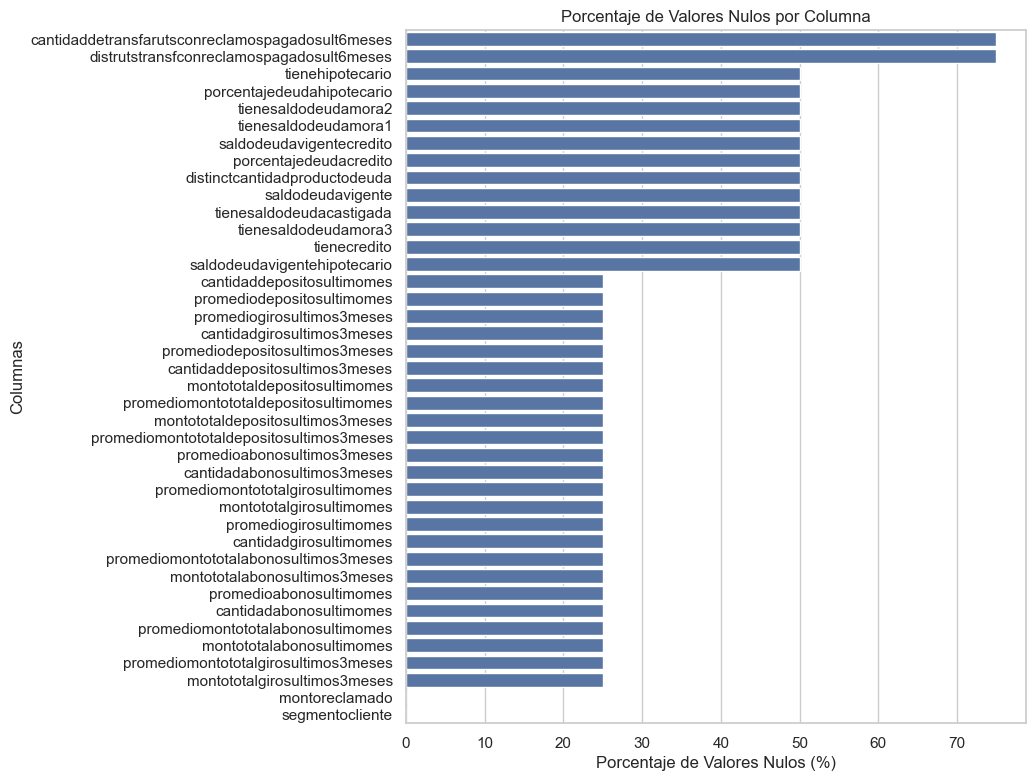

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Contar valores nulos por columna
null_counts = df.isnull().sum()

# Filtrar solo las columnas que tienen valores nulos
null_counts = null_counts[null_counts > 0]

# Verificar si hay columnas con valores nulos
if not null_counts.empty:
    # Calcular el porcentaje de valores nulos
    total_counts = df.shape[0]
    null_percentage = (null_counts / total_counts) * 100

    # Crear un DataFrame con los porcentajes de valores nulos
    null_percentage_df = pd.DataFrame({'column': null_percentage.index, 'null_percentage': null_percentage.values})

    # Crear un gráfico de barras para visualizar los porcentajes de valores nulos por columna
    plt.figure(figsize=(8, 9))
    sns.barplot(x='null_percentage', y='column', data=null_percentage_df.sort_values(by='null_percentage', ascending=False))
    plt.title('Porcentaje de Valores Nulos por Columna')
    plt.xlabel('Porcentaje de Valores Nulos (%)')
    plt.ylabel('Columnas')
    
    # Guardar la imagen en un archivo PNG
    plt.savefig(path_directorio+'Valores_Null.png', transparent=True,  bbox_inches='tight', dpi=300, pad_inches=0.1)
    
    plt.show()
else:
    print("No hay columnas con valores nulos.")

In [26]:
##import pandas as pd
#import seaborn as sns
#import matplotlib.pyplot as plt


#plt.figure(figsize=(10, 6))
#sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
#plt.title('Mapa de valores nulos')
#plt.show()

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2213864 entries, 0 to 2213863
Data columns (total 64 columns):
 #   Column                                            Dtype  
---  ------                                            -----  
 0   rutreclamante                                     object 
 1   idcaso                                            object 
 2   fechacreacioncaso                                 object 
 3   tipocaso                                          object 
 4   montoreclamado                                    float64
 5   clasificacion                                     object 
 6   canalingreso                                      object 
 7   sexo                                              object 
 8   edad                                              int64  
 9   estocivil                                         object 
 10  niveleducacional                                  object 
 11  nacionalidad                                      object 
 12  

In [28]:
# Eliminar columnas no deseadas
df_filtrado_new = df.drop(columns=['rutreclamante', 'idcaso','fechacreacioncaso','label'])

In [29]:
df_filtrado = df_filtrado_new

# Calcular valores nulos totales y porcentaje
total_nulos = df_filtrado.isnull().sum().sum()  # Total de valores nulos
total_valores = df_filtrado.size               # Total de valores en el DataFrame filtrado
porcentaje_nulos = (total_nulos / total_valores) * 100

# Imprimir resultados
print("DataFrame filtrado:")
#print(df_filtrado)
print(f"\nTotal de valores nulos: {total_nulos}")
print(f"Total de valores en la matriz filtrada: {total_valores}")
print(f"Porcentaje de valores nulos: {porcentaje_nulos:.2f}%")

DataFrame filtrado:

Total de valores nulos: 29887796
Total de valores en la matriz filtrada: 132831840
Porcentaje de valores nulos: 22.50%


## Reemplazar valores NULL por 0

In [30]:
columns_to_fill = df.columns

# Reemplazar los valores nulos por 0 en las columnas seleccionadas
df[columns_to_fill] = df[columns_to_fill].fillna(0)

## Valores NULL posterior a reemplazo

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Contar valores nulos por columna
null_counts = df.isnull().sum()

# Filtrar solo las columnas que tienen valores nulos
null_counts = null_counts[null_counts > 0]

# Verificar si hay columnas con valores nulos
if not null_counts.empty:
    # Calcular el porcentaje de valores nulos
    total_counts = df.shape[0]
    null_percentage = (null_counts / total_counts) * 100

    # Crear un DataFrame con los porcentajes de valores nulos
    null_percentage_df = pd.DataFrame({'column': null_percentage.index, 'null_percentage': null_percentage.values})

    # Crear un gráfico de barras para visualizar los porcentajes de valores nulos por columna
    plt.figure(figsize=(8, 10))
    sns.barplot(x='null_percentage', y='column', data=null_percentage_df.sort_values(by='null_percentage', ascending=False))
    plt.title('Porcentaje de Valores Nulos por Columna')
    plt.xlabel('Porcentaje de Valores Nulos (%)')
    plt.ylabel('Columnas')
    plt.show()
else:
    print("No hay columnas con valores nulos.")

No hay columnas con valores nulos.


In [32]:
# Reemplazar los valores en la columna 'label'
df_grafico = df.copy()
df_grafico['label'] = df['label'].replace({0: 'No Auto-Fraude', 1: 'Auto-Fraude'})

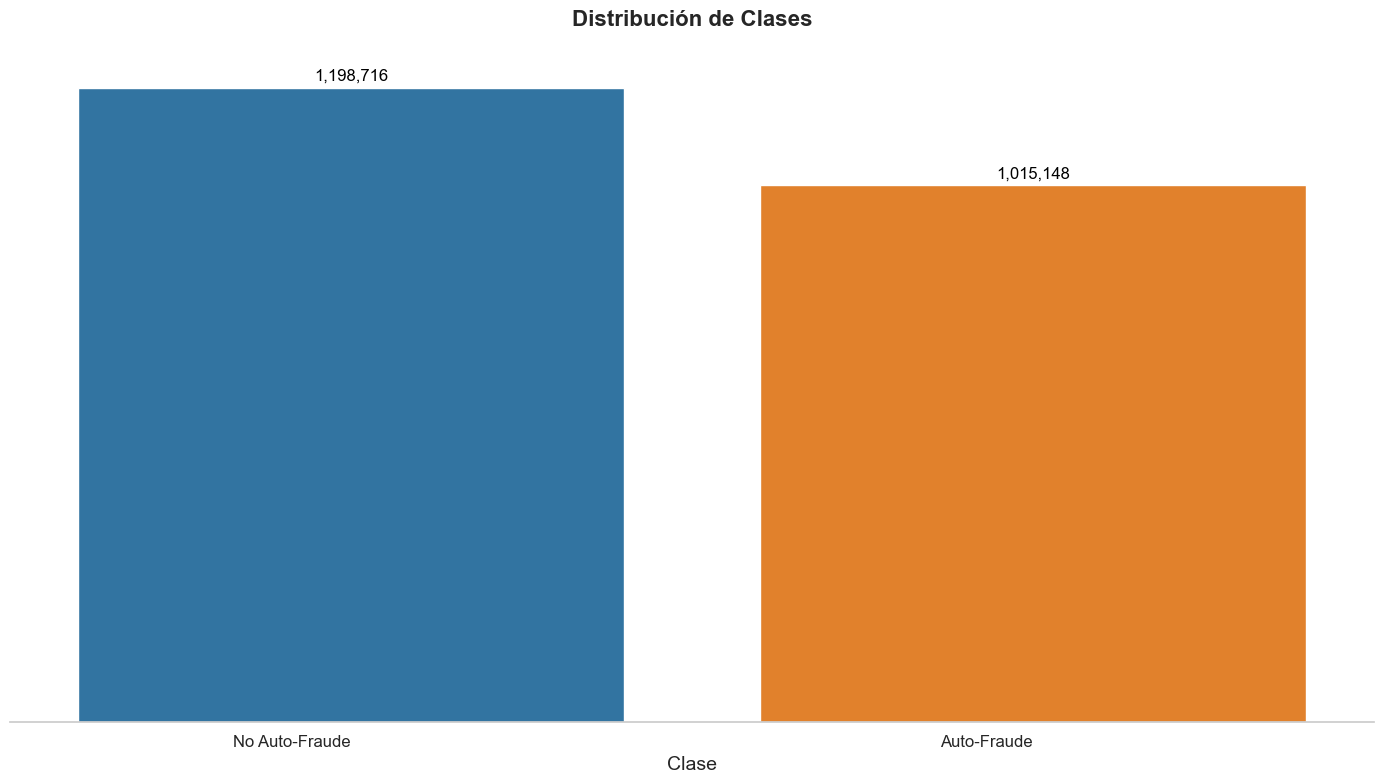

In [33]:
# Configurar el estilo de los gráficos con un tema más atractivo
sns.set(style="whitegrid", palette="pastel")

# Contar la frecuencia de cada clase
class_counts = df_grafico['label'].value_counts()

# Crear un DataFrame con las frecuencias de las clases
class_counts_df = pd.DataFrame({'clase': class_counts.index, 'conteo': class_counts.values})

# Crear un gráfico de barras para visualizar el balanceo de clases
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='clase', y='conteo', data=class_counts_df.sort_values(by='conteo', ascending=False), palette='tab10')

# Personalizar el gráfico
plt.title('Distribución de Clases', fontsize=16, weight='bold')
plt.xlabel('Clase', fontsize=14)
plt.ylabel('Conteo', fontsize=14)
plt.xticks(rotation=0, ha='right', fontsize=12)  # Rotar las etiquetas del eje x para mayor legibilidad

plt.ylim(0, 1300000)

# Eliminar el eje izquierdo y las líneas del final
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Quitar el eje izquierdo
ax.yaxis.set_visible(False)

# Añadir etiquetas a las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=12, color='black', 
                xytext=(0, 5), textcoords='offset points')

plt.tight_layout()  # Ajustar el diseño para no cortar etiquetas
plt.show()

In [34]:
1015148/(1198716 + 1015148)

0.4585412654074505

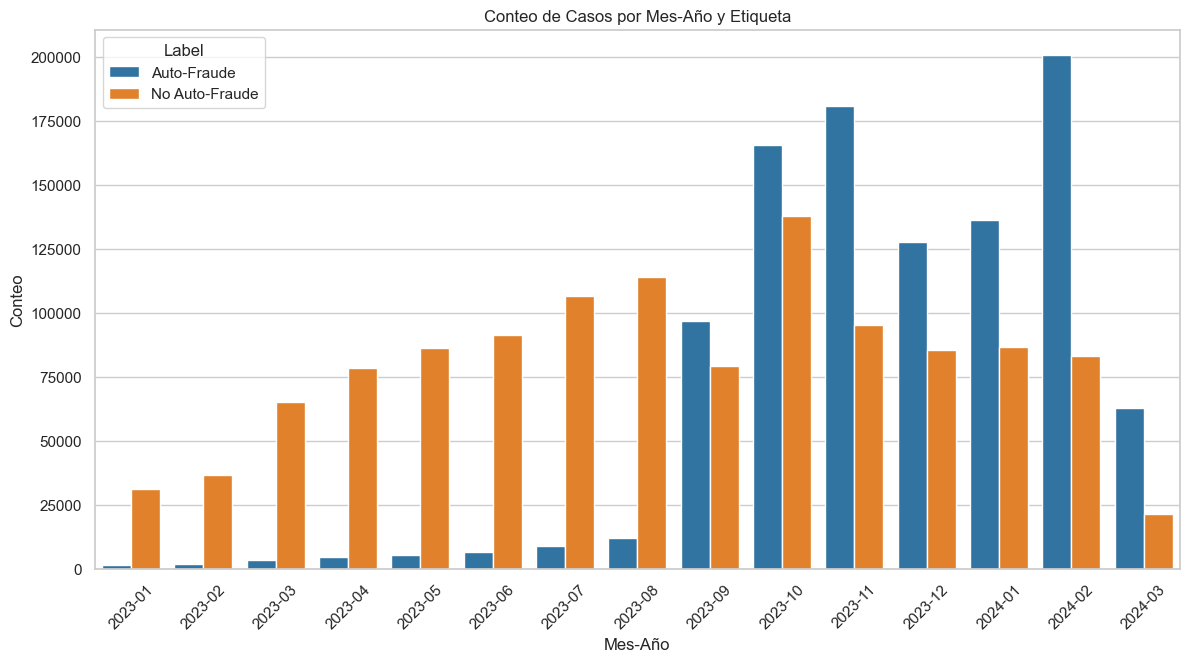

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reemplazar los valores en la columna 'label'
df_grafico_2 = df.copy()
df_grafico_2['label'] = df['label'].replace({0: 'No Auto-Fraude', 1: 'Auto-Fraude'})

# Asegurarse de que la columna de fecha esté en formato datetime
df_grafico_2['date'] = pd.to_datetime(df['fechacreacioncaso'], errors='coerce')  # Convertir la columna 'date' a datetime

# Configurar pandas para mostrar todas las columnas
pd.set_option('display.max_columns', None)

# Reemplazar todos los valores nulos por 0
df_grafico_2.fillna(0, inplace=True)

# Crear una nueva columna con el periodo mes-año
df_grafico_2['month_year'] = df_grafico_2['date'].dt.to_period('M')

# Agrupar los datos por periodo mes-año y etiqueta
grouped_df = df_grafico_2.groupby(['month_year', 'label']).size().reset_index(name='counts')

# Convertir la columna 'month_year' a string para la visualización
grouped_df['month_year'] = grouped_df['month_year'].astype(str)

# Crear el gráfico de barras
plt.figure(figsize=(14, 7))
sns.barplot(data=grouped_df, x='month_year', y='counts', hue='label', palette='tab10')
plt.title('Conteo de Casos por Mes-Año y Etiqueta')
plt.xlabel('Mes-Año')
plt.ylabel('Conteo')
plt.xticks(rotation=45)
plt.legend(title='Label')
plt.show()

### Nos quedamos solo con los reclamos de 2023-09 hacia adelante, dado que hacia atras tiene un comportamiento totalmente distinta la serie

In [36]:
df_respaldo = df.copy()

In [37]:
# Definir la fecha límite
fecha_inicio = '2023-09-01'
fecha_fin = '2024-01-31'

# Filtrar el DataFrame para mantener solo los registros posteriores a la fecha límite
df = df[df['fechacreacioncaso'] >= fecha_inicio]
df = df[df['fechacreacioncaso'] <= fecha_fin]


In [38]:
df.count()

rutreclamante                                       1192384
idcaso                                              1192384
fechacreacioncaso                                   1192384
tipocaso                                            1192384
montoreclamado                                      1192384
                                                     ...   
porcentajedeudahipotecario                          1192384
tienehipotecario                                    1192384
distrutstransfconreclamospagadosult6meses           1192384
cantidaddetransfarutsconreclamospagadosult6meses    1192384
label                                               1192384
Length: 64, dtype: int64

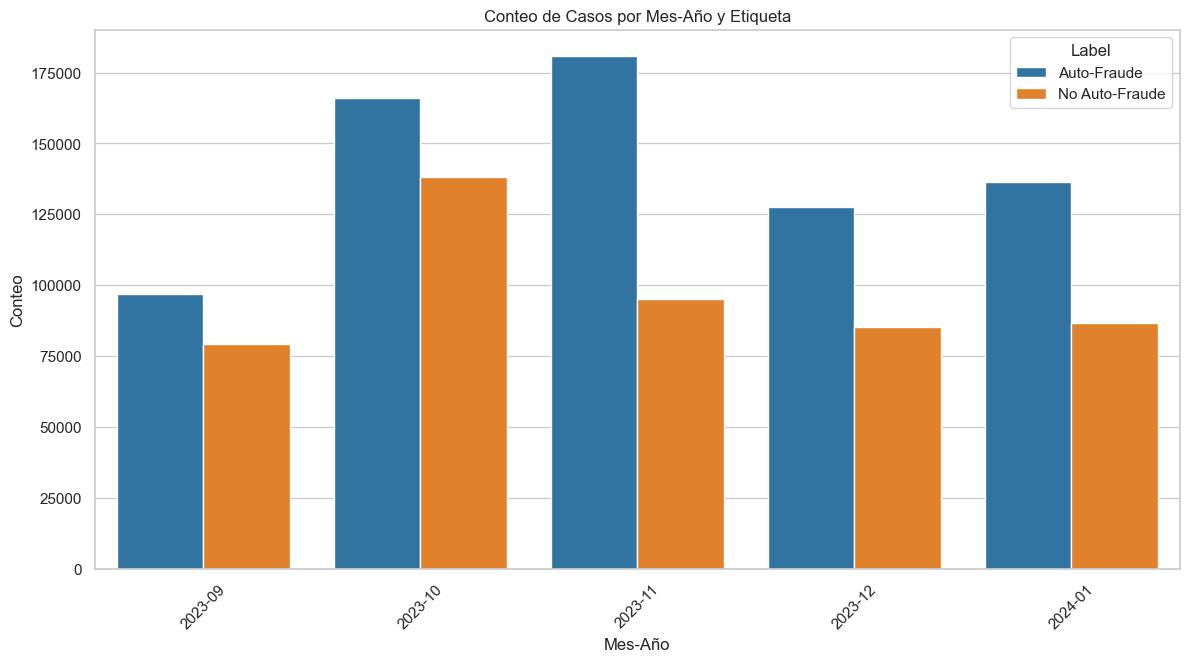

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reemplazar los valores en la columna 'label'
df_grafico_2 = df.copy()
df_grafico_2['label'] = df['label'].replace({0: 'No Auto-Fraude', 1: 'Auto-Fraude'})

# Asegurarse de que la columna de fecha esté en formato datetime
df_grafico_2['date'] = pd.to_datetime(df['fechacreacioncaso'], errors='coerce')  # Convertir la columna 'date' a datetime

# Configurar pandas para mostrar todas las columnas
pd.set_option('display.max_columns', None)

# Reemplazar todos los valores nulos por 0
df_grafico_2.fillna(0, inplace=True)

# Crear una nueva columna con el periodo mes-año
df_grafico_2['month_year'] = df_grafico_2['date'].dt.to_period('M')

# Agrupar los datos por periodo mes-año y etiqueta
grouped_df = df_grafico_2.groupby(['month_year', 'label']).size().reset_index(name='counts')

# Convertir la columna 'month_year' a string para la visualización
grouped_df['month_year'] = grouped_df['month_year'].astype(str)

# Crear el gráfico de barras
plt.figure(figsize=(14, 7))
sns.barplot(data=grouped_df, x='month_year', y='counts', hue='label', palette='tab10')
plt.title('Conteo de Casos por Mes-Año y Etiqueta')
plt.xlabel('Mes-Año')
plt.ylabel('Conteo')
plt.xticks(rotation=45)
plt.legend(title='Label')
plt.show()

### Eliminación de Outliers

In [40]:
df.describe()

,montoreclamado,edad,cantidaddehijos,cantidatrxdebitoultimomes,promediotrxdebitoultimomes,montototaldebitoultimomes,promediomontototaldebitoultimomes,cantidatrxdebitoultimos3meses,promediotrxdebitoultimos3meses,montototaldebitoultimos3meses,promediomontototaldebitoultimos3meses,cantidaddepositosultimomes,promediodepositosultimomes,montototaldepositosultimomes,promediomontototaldepositosultimomes,cantidaddepositosultimos3meses,promediodepositosultimos3meses,montototaldepositosultimos3meses,promediomontototaldepositosultimos3meses,cantidadabonosultimomes,promedioabonosultimomes,montototalabonosultimomes,promediomontototalabonosultimomes,cantidadabonosultimos3meses,promedioabonosultimos3meses,montototalabonosultimos3meses,promediomontototalabonosultimos3meses,cantidadgirosultimomes,promediogirosultimomes,montototalgirosultimomes,promediomontototalgirosultimomes,cantidadgirosultimos3meses,promediogirosultimos3meses,montototalgirosultimos3meses,promediomontototalgirosultimos3meses,distinctcantidadproductodeuda,saldodeudavigente,tienesaldodeudamora1,tienesaldodeudamora2,tienesaldodeudamora3,tienesaldodeudacastigada,saldodeudavigentecredito,porcentajedeudacredito,tienecredito,saldodeudavigentehipotecario,porcentajedeudahipotecario,tienehipotecario,distrutstransfconreclamospagadosult6meses,cantidaddetransfarutsconreclamospagadosult6meses,label
count,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06,1.192384e+06
mean,4.263197e+05,3.453038e+01,1.189922e+00,1.839431e+01,7.032634e-01,2.092453e+05,9.733919e+03,5.329024e+01,7.395537e-01,5.682494e+05,9.272085e+03,8.798189e-01,3.318285e-01,1.853215e+05,1.103985e+05,2.168347e+00,4.091241e-01,3.426512e+05,1.233406e+05,1.337627e+01,5.692906e-01,7.342983e+05,4.998122e+04,3.804975e+01,5.775178e-01,1.929984e+06,4.636641e+04,2.966965e+00,5.598306e-01,3.542782e+05,9.588938e+04,7.363179e+00,6.099562e-01,6.576582e+05,8.584706e+04,7.292114e-02,6.759875e+05,1.092266e-02,6.598545e-03,5.176185e-03,2.262694e-03,3.368443e+05,2.632723e+00,3.362172e-02,3.172579e+05,6.397799e-01,8.941750e-03,9.528155e-01,3.926995e+00,5.935839e-01
std,4.877655e+05,1.377228e+01,1.414220e+00,2.406394e+01,4.568196e-01,3.319517e+05,2.040933e+04,6.626113e+01,4.388783e-01,8.375617e+05,1.667202e+04,2.613973e+00,4.708700e-01,7.100871e+05,3.739769e+05,6.998922e+00,4.916724e-01,1.582840e+06,5.093646e+05,3.681694e+01,4.951757e-01,1.949801e+06,3.361307e+05,1.040360e+02,4.939546e-01,5.153320e+06,3.675005e+05,5.707865e+00,4.964076e-01,8.525540e+05,1.961604e+05,1.486080e+01,4.877600e-01,1.621265e+06,2.186738e+05,3.526766e-01,1.239304e+08,1.039392e-01,8.096302e-02,7.175929e-02,4.751396e-02,1.238432e+08,1.498282e+01,1.802535e-01,4.336439e+06,7.171435e+00,9.413715e-02,2.943654e+00,1.507863e+01,4.911642e-01
min,-2.123409e+06,1.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.906000e+04,2.400

In [41]:
df[0:1]

,rutreclamante,idcaso,fechacreacioncaso,tipocaso,montoreclamado,clasificacion,canalingreso,sexo,edad,estocivil,niveleducacional,nacionalidad,segmentocliente,comuna,ciudad,region,cantidaddehijos,cantidatrxdebitoultimomes,promediotrxdebitoultimomes,montototaldebitoultimomes,promediomontototaldebitoultimomes,cantidatrxdebitoultimos3meses,promediotrxdebitoultimos3meses,montototaldebitoultimos3meses,promediomontototaldebitoultimos3meses,cantidaddepositosultimomes,promediodepositosultimomes,montototaldepositosultimomes,promediomontototaldepositosultimomes,cantidaddepositosultimos3meses,promediodepositosultimos3meses,montototaldepositosultimos3meses,promediomontototaldepositosultimos3meses,cantidadabonosultimomes,promedioabonosultimomes,montototalabonosultimomes,promediomontototalabonosultimomes,cantidadabonosultimos3meses,promedioabonosultimos3meses,montototalabonosultimos3meses,promediomontototalabonosultimos3meses,cantidadgirosultimomes,promediogirosultimomes,montototalgirosultimomes,promediomontototalgirosultimomes,cantidadgirosultimos3meses,promediogirosultimos3meses,montototalgirosultimos3meses,promediomontototalgirosultimos3meses,distinctcantidadproductodeuda,saldodeudavigente,tienesaldodeudamora1,tienesaldodeudamora2,tienesaldodeudamora3,tienesaldodeudacastigada,saldodeudavigentecredito,porcentajedeudacredito,tienecredito,saldodeudavigentehipotecario,porcentajedeudahipotecario,tienehipotecario,distrutstransfconreclamospagadosult6meses,cantidaddetransfarutsconreclamospagadosult6meses,label
3,186145526,5004V00001UbrjkQAB,2023-11-28,TNR,790000.0,tnr presencial,Telefonia,masculino,29,soltero,medio/secundario,chilena,PERSONAS,CERRO NAVIA,SANTIAGO,REGION METROPOLITANA,0,22,1.0,98589,4481,81,1.0,515705,6367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [42]:
df_numerico = df.copy()

In [43]:
df_numerico[0:1]

,rutreclamante,idcaso,fechacreacioncaso,tipocaso,montoreclamado,clasificacion,canalingreso,sexo,edad,estocivil,niveleducacional,nacionalidad,segmentocliente,comuna,ciudad,region,cantidaddehijos,cantidatrxdebitoultimomes,promediotrxdebitoultimomes,montototaldebitoultimomes,promediomontototaldebitoultimomes,cantidatrxdebitoultimos3meses,promediotrxdebitoultimos3meses,montototaldebitoultimos3meses,promediomontototaldebitoultimos3meses,cantidaddepositosultimomes,promediodepositosultimomes,montototaldepositosultimomes,promediomontototaldepositosultimomes,cantidaddepositosultimos3meses,promediodepositosultimos3meses,montototaldepositosultimos3meses,promediomontototaldepositosultimos3meses,cantidadabonosultimomes,promedioabonosultimomes,montototalabonosultimomes,promediomontototalabonosultimomes,cantidadabonosultimos3meses,promedioabonosultimos3meses,montototalabonosultimos3meses,promediomontototalabonosultimos3meses,cantidadgirosultimomes,promediogirosultimomes,montototalgirosultimomes,promediomontototalgirosultimomes,cantidadgirosultimos3meses,promediogirosultimos3meses,montototalgirosultimos3meses,promediomontototalgirosultimos3meses,distinctcantidadproductodeuda,saldodeudavigente,tienesaldodeudamora1,tienesaldodeudamora2,tienesaldodeudamora3,tienesaldodeudacastigada,saldodeudavigentecredito,porcentajedeudacredito,tienecredito,saldodeudavigentehipotecario,porcentajedeudahipotecario,tienehipotecario,distrutstransfconreclamospagadosult6meses,cantidaddetransfarutsconreclamospagadosult6meses,label
3,186145526,5004V00001UbrjkQAB,2023-11-28,TNR,790000.0,tnr presencial,Telefonia,masculino,29,soltero,medio/secundario,chilena,PERSONAS,CERRO NAVIA,SANTIAGO,REGION METROPOLITANA,0,22,1.0,98589,4481,81,1.0,515705,6367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [44]:
# Array de columnas que deseas eliminar
columns_to_drop_numerico = ['rutreclamante','idcaso','fechacreacioncaso','tipocaso','clasificacion','canalingreso','sexo','estocivil','niveleducacional','nacionalidad','segmentocliente','comuna','ciudad','region']  # Reemplaza con los nombres reales de las columnas

# Eliminar las columnas especificadas en el array
df_numerico_number = df_numerico.drop(columns=columns_to_drop_numerico)

In [45]:
import numpy as np

X = df_numerico_number.to_numpy()
cov_matrix = np.cov(X.T)
cov_matrix_inv = np.linalg.pinv(cov_matrix)  # Usar pseudo-inversa

mean = np.mean(X, axis=0)

In [46]:
# Calcular la distancia de Mahalanobis
from scipy.spatial.distance import mahalanobis
df_numerico_number['mahalanobis'] = [mahalanobis(x, mean, cov_matrix_inv) for x in X]

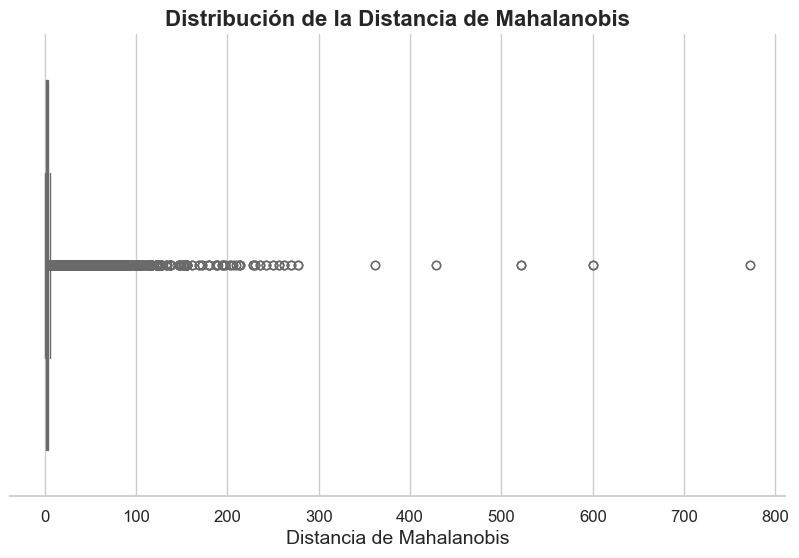

In [47]:
# Crear una figura y un eje para el gráfico
plt.figure(figsize=(10, 6))

# Crear el boxplot
sns.boxplot(data=df_numerico_number, x="mahalanobis", palette="Set3")

# Personalizar el gráfico
plt.title('Distribución de la Distancia de Mahalanobis', fontsize=16, weight='bold')
plt.xlabel('Distancia de Mahalanobis', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Opcional: añadir un borde y cambiar el color de fondo
sns.despine(left=True)

# Guardar el gráfico en un archivo PNG
# Guardar la imagen en un archivo PNG
plt.savefig(path_directorio+'mahalanobis.png', transparent=True,  bbox_inches='tight', dpi=300, pad_inches=0.1)

# Mostrar el gráfico
plt.show()

In [48]:
Q1 = df_numerico_number['mahalanobis'].quantile(0.25)
Q3 = df_numerico_number['mahalanobis'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

In [49]:
outliers = df_numerico_number[(df_numerico_number['mahalanobis'] < limite_inferior) | (df_numerico_number['mahalanobis'] > limite_superior)]

In [50]:
# Ordenar el DataFrame por la columna 'edad' en orden ascendente
df_sorted = outliers.sort_values(by='mahalanobis', ascending=False)

In [51]:
df_sorted[0:1]

,montoreclamado,edad,cantidaddehijos,cantidatrxdebitoultimomes,promediotrxdebitoultimomes,montototaldebitoultimomes,promediomontototaldebitoultimomes,cantidatrxdebitoultimos3meses,promediotrxdebitoultimos3meses,montototaldebitoultimos3meses,promediomontototaldebitoultimos3meses,cantidaddepositosultimomes,promediodepositosultimomes,montototaldepositosultimomes,promediomontototaldepositosultimomes,cantidaddepositosultimos3meses,promediodepositosultimos3meses,montototaldepositosultimos3meses,promediomontototaldepositosultimos3meses,cantidadabonosultimomes,promedioabonosultimomes,montototalabonosultimomes,promediomontototalabonosultimomes,cantidadabonosultimos3meses,promedioabonosultimos3meses,montototalabonosultimos3meses,promediomontototalabonosultimos3meses,cantidadgirosultimomes,promediogirosultimomes,montototalgirosultimomes,promediomontototalgirosultimomes,cantidadgirosultimos3meses,promediogirosultimos3meses,montototalgirosultimos3meses,promediomontototalgirosultimos3meses,distinctcantidadproductodeuda,saldodeudavigente,tienesaldodeudamora1,tienesaldodeudamora2,tienesaldodeudamora3,tienesaldodeudacastigada,saldodeudavigentecredito,porcentajedeudacredito,tienecredito,saldodeudavigentehipotecario,porcentajedeudahipotecario,tienehipotecario,distrutstransfconreclamospagadosult6meses,cantidaddetransfarutsconreclamospagadosult6meses,label,mahalanobis
1055169,272325.0,22,0,21,1.0,1022858,48708,82,1.0,3256986,39719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9.558781e+10,0.0,0.0,0.0,0.0,9.558781e+10,100.0,1.0,0.0,0.0,0.0,1.0,1.0,0,771.872077


In [52]:
indices_para_eliminar = outliers.index
#df = df.drop(indices_para_eliminar)
df_final_limpio = df.drop(indices_para_eliminar)

In [53]:
df_final_limpio[0:1]

,rutreclamante,idcaso,fechacreacioncaso,tipocaso,montoreclamado,clasificacion,canalingreso,sexo,edad,estocivil,niveleducacional,nacionalidad,segmentocliente,comuna,ciudad,region,cantidaddehijos,cantidatrxdebitoultimomes,promediotrxdebitoultimomes,montototaldebitoultimomes,promediomontototaldebitoultimomes,cantidatrxdebitoultimos3meses,promediotrxdebitoultimos3meses,montototaldebitoultimos3meses,promediomontototaldebitoultimos3meses,cantidaddepositosultimomes,promediodepositosultimomes,montototaldepositosultimomes,promediomontototaldepositosultimomes,cantidaddepositosultimos3meses,promediodepositosultimos3meses,montototaldepositosultimos3meses,promediomontototaldepositosultimos3meses,cantidadabonosultimomes,promedioabonosultimomes,montototalabonosultimomes,promediomontototalabonosultimomes,cantidadabonosultimos3meses,promedioabonosultimos3meses,montototalabonosultimos3meses,promediomontototalabonosultimos3meses,cantidadgirosultimomes,promediogirosultimomes,montototalgirosultimomes,promediomontototalgirosultimomes,cantidadgirosultimos3meses,promediogirosultimos3meses,montototalgirosultimos3meses,promediomontototalgirosultimos3meses,distinctcantidadproductodeuda,saldodeudavigente,tienesaldodeudamora1,tienesaldodeudamora2,tienesaldodeudamora3,tienesaldodeudacastigada,saldodeudavigentecredito,porcentajedeudacredito,tienecredito,saldodeudavigentehipotecario,porcentajedeudahipotecario,tienehipotecario,distrutstransfconreclamospagadosult6meses,cantidaddetransfarutsconreclamospagadosult6meses,label
3,186145526,5004V00001UbrjkQAB,2023-11-28,TNR,790000.0,tnr presencial,Telefonia,masculino,29,soltero,medio/secundario,chilena,PERSONAS,CERRO NAVIA,SANTIAGO,REGION METROPOLITANA,0,22,1.0,98589,4481,81,1.0,515705,6367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


### EDA Graficos de densidad

#### EDA Monto Reclamado

In [54]:
df_graficos_final = df_final_limpio.copy()

In [55]:
# Asegúrate de que la columna de etiquetas está correctamente definida
df_graficos_final['Categoría'] = df_graficos_final['label'].replace({0: 'No Auto-Fraude', 1: 'Auto-Fraude'})
df_graficos_final['region'] = df_graficos_final['region'].str.strip()

Valores antes de limpieza:
count    1.099095e+06
mean     4.210352e+05
std      3.374760e+05
min     -4.154000e+05
25%      1.000000e+05
50%      4.000000e+05
75%      6.500000e+05
max      3.300000e+06
Name: montoreclamado, dtype: float64
Lambda Box-Cox: 0.44349169350415346


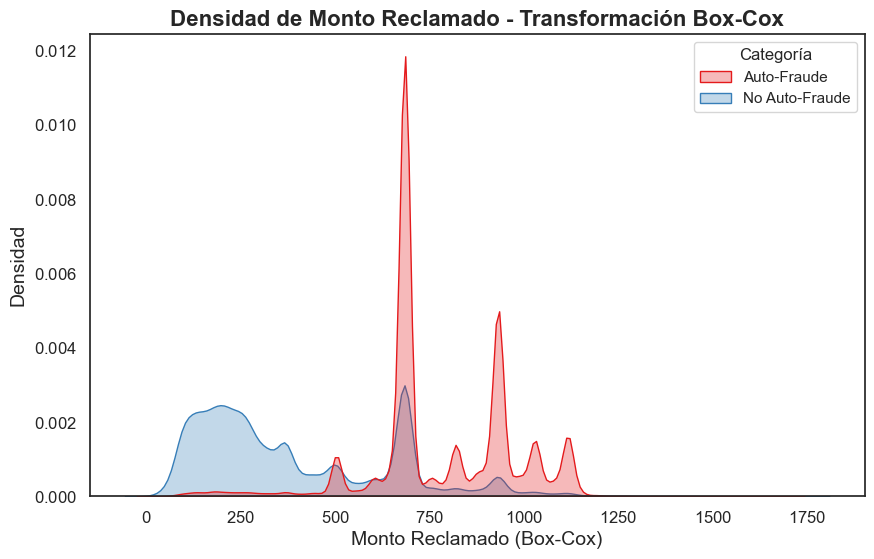

In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from scipy.stats import boxcox

# Configurar el estilo de los gráficos
sns.set(style="white")

# Paso 1: Verificar y limpiar los datos
print("Valores antes de limpieza:")
print(df_graficos_final['montoreclamado'].describe())

# Eliminar valores NaN o no numéricos
df_graficos_final = df_graficos_final.dropna(subset=['montoreclamado'])

# Filtrar valores estrictamente positivos
df_graficos_final = df_graficos_final[df_graficos_final['montoreclamado'] > 0]

# Paso 2: Aplicar la transformación Box-Cox
df_graficos_final['montoreclamado_boxcox'], lambda_boxcox = boxcox(df_graficos_final['montoreclamado'])

# Imprimir el valor de lambda para referencia
print(f"Lambda Box-Cox: {lambda_boxcox}")

# Paso 3: Crear la figura
plt.figure(figsize=(10, 6))

# Crear el gráfico de densidad con el monto reclamado transformado
sns.kdeplot(
    data=df_graficos_final, 
    x='montoreclamado_boxcox', 
    hue='Categoría', 
    fill=True, 
    common_norm=False, 
    palette="Set1", 
    alpha=0.3
)

# Personalizar el gráfico
plt.title('Densidad de Monto Reclamado - Transformación Box-Cox', fontsize=16, weight='bold')
plt.xlabel('Monto Reclamado (Box-Cox)', fontsize=14)
plt.ylabel('Densidad', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Quitar la notación científica de ambos ejes
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.gca().yaxis.offsetText.set_visible(False)  # Ocultar notación científica en eje y
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.gca().xaxis.offsetText.set_visible(False)  # Ocultar notación científica en eje x

# Guardar el gráfico en un archivo PNG
path_directorio = "./"  # Ajusta la ruta donde guardarás la imagen
plt.savefig(path_directorio + 'Grafico_densidad_monto_reclamado_boxcox.png', bbox_inches='tight', dpi=300, transparent=True)

# Mostrar el gráfico
plt.show()

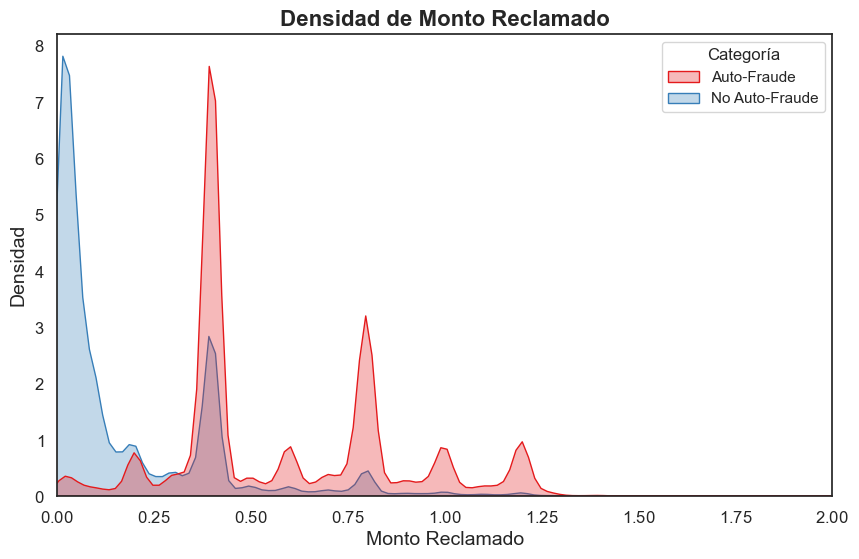

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Configurar el estilo de los gráficos
sns.set(style="white")

# Crear la figura
plt.figure(figsize=(10, 6))

# Crear el gráfico de densidad
sns.kdeplot(data=df_graficos_final, x='montoreclamado', hue='Categoría', fill=True, common_norm=False, palette="Set1", alpha=0.3)

# Personalizar el gráfico
plt.title('Densidad de Monto Reclamado', fontsize=16, weight='bold')
plt.xlabel('Monto Reclamado', fontsize=14)
plt.ylabel('Densidad', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Quitar la notación científica de ambos ejes
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.gca().yaxis.offsetText.set_visible(False)  # Ocultar notación científica en eje y
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.gca().xaxis.offsetText.set_visible(False)  # Ocultar notación científica en eje x

# Establecer límites personalizados en el eje x
plt.xlim(0, 2_000_000)

# Guardar el gráfico en un archivo PNG
plt.savefig(path_directorio+'Grafico_densidad_monto_reclamado.png', bbox_inches='tight', dpi=300, transparent=True)

# Mostrar el gráfico
plt.show()

In [58]:
analizar_correlation(df_graficos_final,'montoreclamado','label')

Pruebas de Normalidad:
- Shapiro-Wilk Test:
  - Estadístico: 0.9088
  - P-valor: 0.00000000
  - Conclusión: La variable no sigue una distribución normal.

- Kolmogorov-Smirnov Test:
  - Estadístico: 0.2059
  - P-valor: 0.00000000
  - Conclusión: La variable no sigue una distribución normal.

Pruebas de Correlación:
- Método: Spearman
  - Coeficiente de Correlación: 0.6406
  - P-valor: 0.00000000
  - Conclusión: Existe una correlación significativa entre las variables.

Pruebas T-Student:
- Estadístico T: 752.5784
- P-valor: 0.00000000
- Conclusión: Hay una diferencia significativa entre los grupos en la variable evaluada.



#### EDA Monto Clasificación

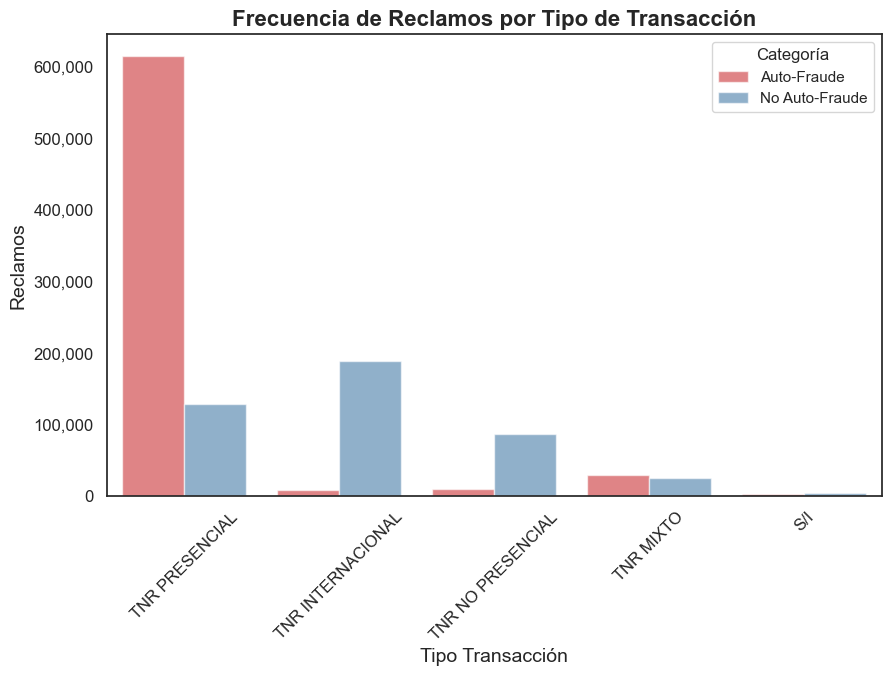

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Configurar el estilo de los gráficos
sns.set(style="white")

# Crear la figura
plt.figure(figsize=(10, 6))

df_graficos_final['clasificacion'] = df_graficos_final['clasificacion'].str.upper()

# Crear el gráfico de conteo
ax = sns.countplot(data=df_graficos_final, x='clasificacion', hue='Categoría', palette="Set1", alpha=0.6)

# Personalizar el gráfico
plt.title('Frecuencia de Reclamos por Tipo de Transacción', fontsize=16, weight='bold')
plt.xlabel('Tipo Transacción', fontsize=14)
plt.ylabel('Reclamos', fontsize=14)
plt.xticks(fontsize=12, rotation=45)  # Rotar etiquetas si es necesario
plt.yticks(fontsize=12)

# Función para formatear los ticks del eje y con separadores de miles
def thousands_formatter(x, pos):
    return f'{int(x):,}'

# Aplicar el formateador de separadores de miles al eje y
ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Guardar el gráfico en un archivo PNG
plt.savefig(path_directorio+'Conteo_relamo_tipo_transaccion.png', bbox_inches='tight', dpi=300,transparent=True)

# Mostrar el gráfico
plt.show()

In [60]:
analizar_categorical(df_graficos_final, 'clasificacion', 'label')

Prueba de Chi-Cuadrado:
- Estadístico: 520302.2440
- P-valor: 0.0000
- Conclusión: Existe una relación significativa entre las variables.

Impacto por Categoría:
- Categoría 'TNR INTERNACIONAL': Impacto Total = 262238.1816
- Categoría 'TNR PRESENCIAL': Impacto Total = 152954.4380
- Categoría 'TNR NO PRESENCIAL': Impacto Total = 102955.4315
- Categoría 'S/I': Impacto Total = 1172.5752
- Categoría 'TNR MIXTO': Impacto Total = 981.6177


#### EDA Tipo Caso

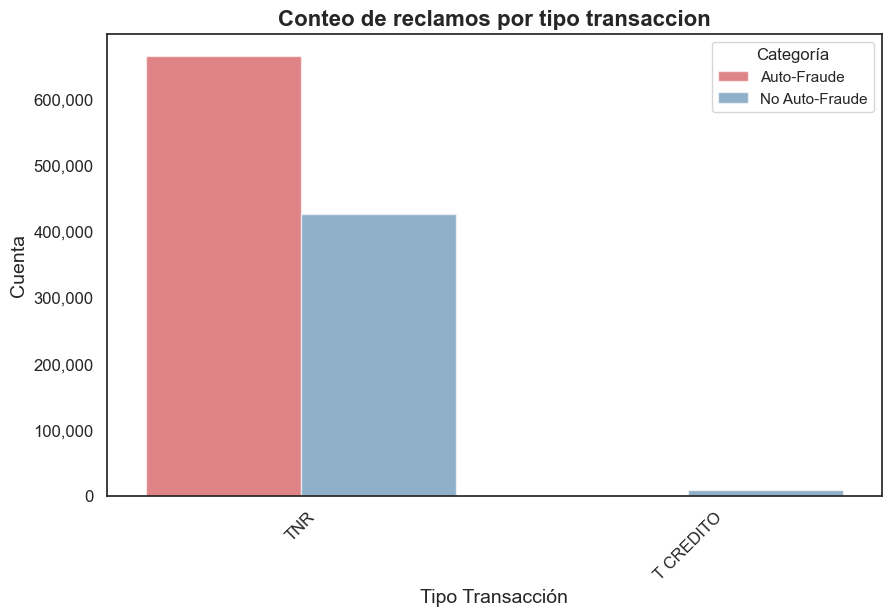

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Configurar el estilo de los gráficos
sns.set(style="white")

# Crear la figura
plt.figure(figsize=(10, 6))

# Crear el gráfico de conteo
ax = sns.countplot(data=df_graficos_final, x='tipocaso', hue='Categoría', palette="Set1", alpha=0.6)

# Personalizar el gráfico
plt.title('Conteo de reclamos por tipo transaccion', fontsize=16, weight='bold')
plt.xlabel('Tipo Transacción', fontsize=14)
plt.ylabel('Cuenta', fontsize=14)
plt.xticks(fontsize=12, rotation=45)  # Rotar etiquetas si es necesario
plt.yticks(fontsize=12)

# Función para formatear los ticks del eje y con separadores de miles
def thousands_formatter(x, pos):
    return f'{int(x):,}'

# Aplicar el formateador de separadores de miles al eje y
ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Guardar el gráfico en un archivo PNG
plt.savefig(path_directorio+'Conteo_relamo_tipo_caso.png', bbox_inches='tight', dpi=300,transparent=True)

# Mostrar el gráfico
plt.show()

In [62]:
analizar_categorical(df_graficos_final, 'tipocaso', 'label')

Prueba de Chi-Cuadrado:
- Estadístico: 12424.0912
- P-valor: 0.0000
- Conclusión: Existe una relación significativa entre las variables.

Impacto por Categoría:
- Categoría 'T CREDITO': Impacto Total = 12332.8866
- Categoría 'TNR': Impacto Total = 93.7195


In [63]:
# Crear un diccionario de mapeo para las regiones
region_mapping = {
    'REGION METROPOLITANA': 'RM',
    'DECIMA CUARTA REGION': 'XIV',
    'SEPTIMA REGION': 'VII',
    'SEXTA REGION': 'VI',
    'NOVENA REGION': 'IX',
    'QUINTA REGION': 'V',
    'PRIMERA REGION': 'I',
    'SEGUNDA REGION': 'II',
    'OCTAVA REGION': 'VIII',
    'TERCERA REGION': 'III',
    'DECIMA SEXTA REGION': 'XVI',
    'DECIMA QUINTA REGION': 'XV',
    'DECIMA REGION': 'X',
    'DUODECIMA REGION': 'XII',
    'UNDECIMA REGION': 'XI',
    'CUARTA REGION': 'IV',
    'SinRegion': 'Sin Region'
}

# Reemplazar los nombres de las regiones por sus equivalentes en números romanos
df_graficos_final['Region_Final'] = df_graficos_final['region'].replace(region_mapping)

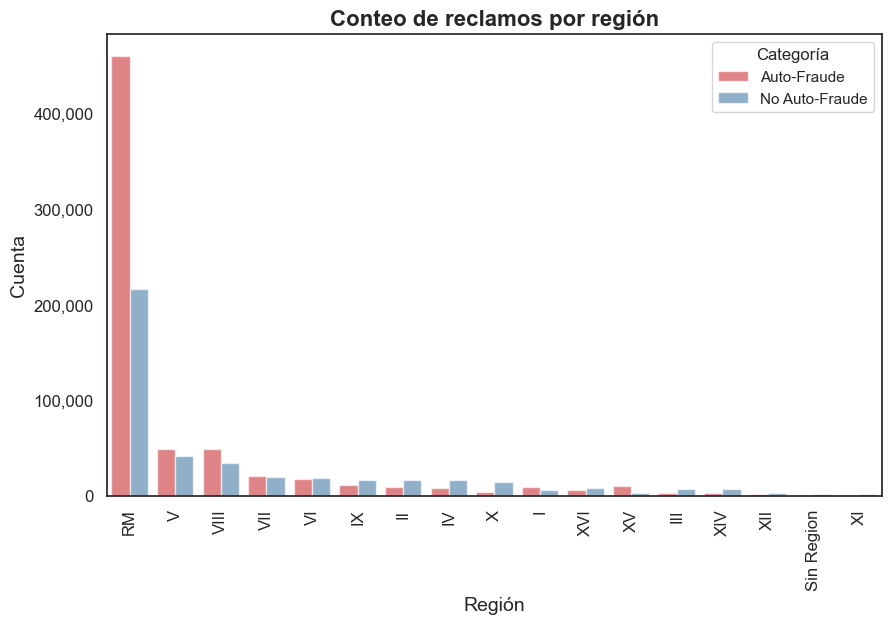

In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Calcular los conteos totales por región
region_order = df_graficos_final['Region_Final'].value_counts().index

# Configurar el estilo de los gráficos
sns.set(style="white")

# Crear la figura
plt.figure(figsize=(10, 6))

# Crear el gráfico de conteo, ordenando por los conteos totales
ax = sns.countplot(data=df_graficos_final, x='Region_Final', hue='Categoría', order=region_order, palette="Set1", alpha=0.6)

# Personalizar el gráfico
plt.title('Conteo de reclamos por región', fontsize=16, weight='bold')
plt.xlabel('Región', fontsize=14)
plt.ylabel('Cuenta', fontsize=14)
plt.xticks(fontsize=12, rotation=90)  # Rotar etiquetas si es necesario
plt.yticks(fontsize=12)

# Función para formatear los ticks del eje y con separadores de miles
def thousands_formatter(x, pos):
    return f'{int(x):,}'

# Aplicar el formateador de separadores de miles al eje y
ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Guardar el gráfico en un archivo PNG
plt.savefig(path_directorio+'Conteo_reclamo_por_region.png', bbox_inches='tight', dpi=300,transparent=True)

# Mostrar el gráfico
plt.show()

In [65]:
analizar_categorical(df_graficos_final, 'Region_Final', 'label')

Prueba de Chi-Cuadrado:
- Estadístico: 66443.7337
- P-valor: 0.0000
- Conclusión: Existe una relación significativa entre las variables.

Impacto por Categoría:
- Categoría 'RM': Impacto Total = 15803.8392
- Categoría 'X': Impacto Total = 11097.3497
- Categoría 'IV': Impacto Total = 7735.5098
- Categoría 'II': Impacto Total = 6546.9475
- Categoría 'IX': Impacto Total = 4499.1026
- Categoría 'III': Impacto Total = 4219.2124
- Categoría 'XIV': Impacto Total = 3928.4742
- Categoría 'VI': Impacto Total = 2218.7185
- Categoría 'XV': Impacto Total = 1946.2646
- Categoría 'V': Impacto Total = 1701.9359
- Categoría 'XVI': Impacto Total = 1701.6271
- Categoría 'XI': Impacto Total = 1469.1874
- Categoría 'VII': Impacto Total = 1464.0693
- Categoría 'XII': Impacto Total = 1266.3049
- Categoría 'Sin Region': Impacto Total = 738.3280
- Categoría 'VIII': Impacto Total = 86.8373
- Categoría 'I': Impacto Total = 20.0252


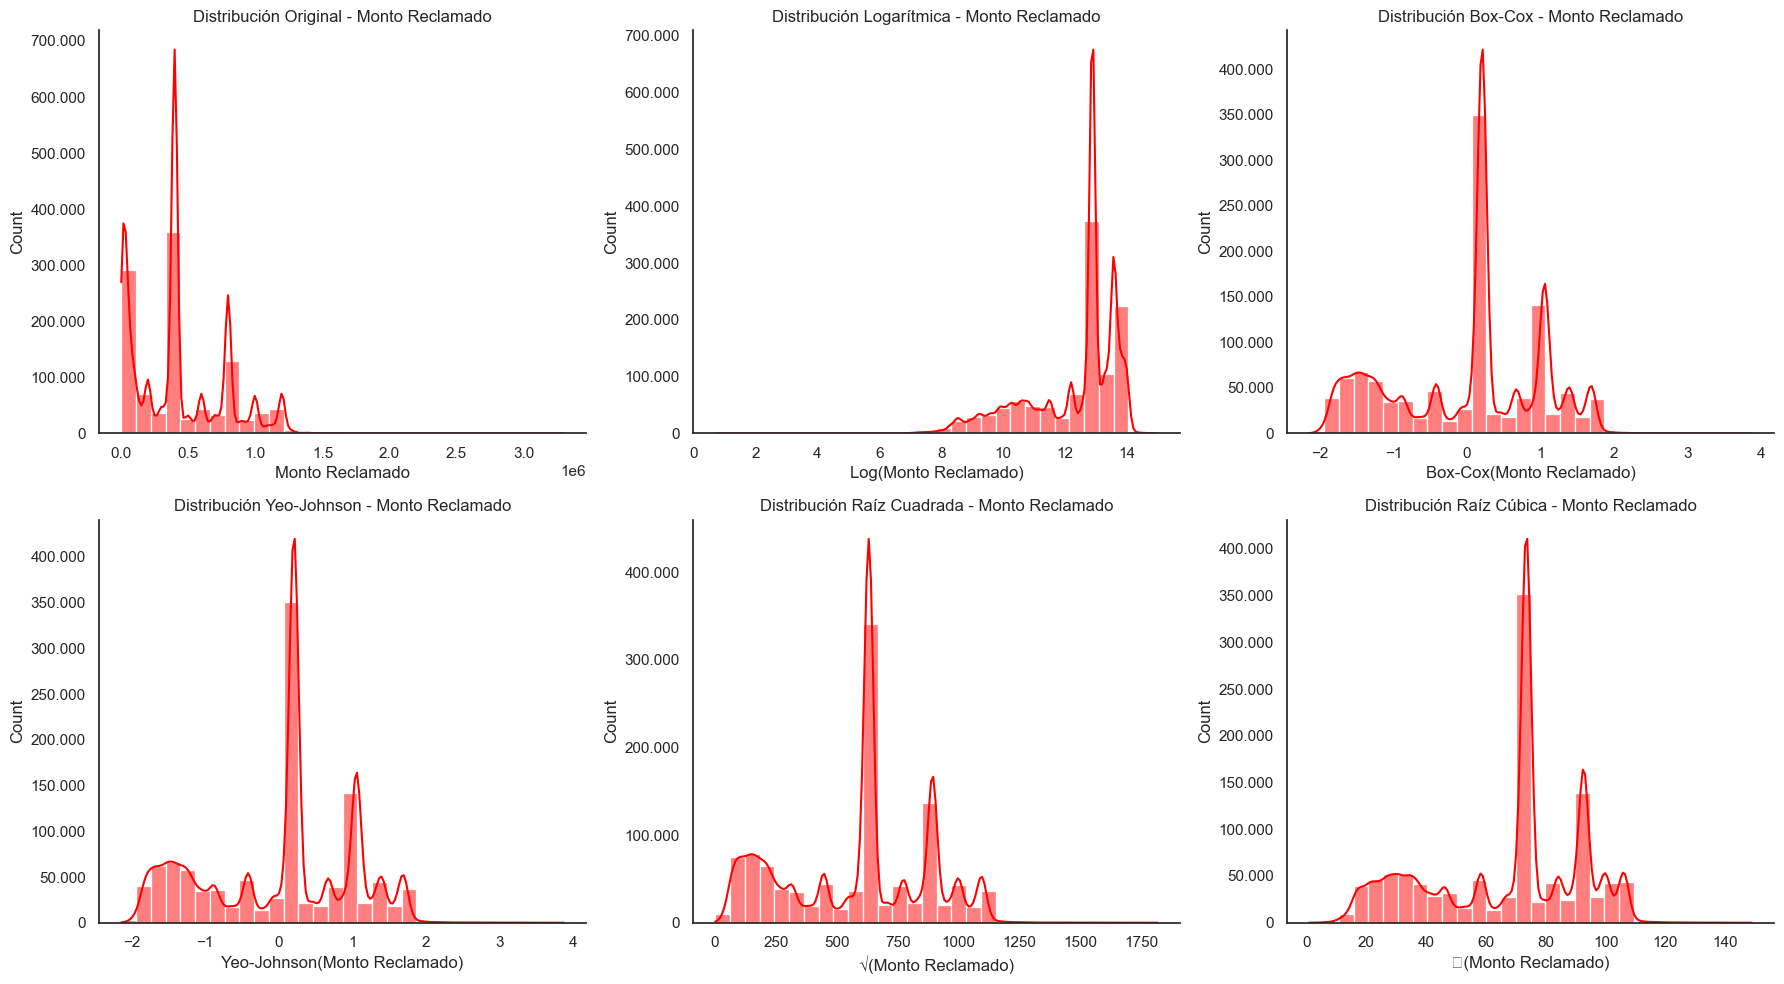

In [66]:
graficar_transformaciones(df_graficos_final, "montoreclamado", nombre_variable="Monto Reclamado")

### Eliminación de Correlacionadas

In [67]:
#df_final_limpio

In [68]:
#path_json_correlacciones = 'C:/Users/jmend/OneDrive/Escritorio/Magister/Capstone/variables_correlacionadas_capstone.json'
#correlated_columns = detectar_y_guardar_variables_correlacionadas(df_final_limpio,0.85,path_json_correlacciones)
#print("Columnas altamente correlacionadas detectadas y guardadas:", correlated_columns)

In [69]:
#df_final_limpio = eliminar_columnas_desde_json(df_final_limpio,path_json_correlacciones)

### Crear Dummies

In [70]:
# Lista de columnas a convertir en variables dummy
#columns_to_convert = [
#    'clasificacion', 
#    'estocivil', 
#    'nacionalidad', 
#    'sexo', 
#    'niveleducacional', 
#    'tipocaso', 
#    'canalingreso', 
#    'segmentocliente', 
#    'region'
#]


# Iterar sobre las columnas para aplicar la función
#for column in columns_to_convert:
#        crear_dummies_sin_multicolinealidad_rf(
#        df_final_limpio, 
#        column, 
#        'label',  # Cambia 'label' si es necesario
#        f'C:/Users/jmend/OneDrive/Escritorio/Magister/Capstone/dummies_{column}.json'  # Archivo JSON específico por columna
#    )

In [71]:
df_final_limpio[0:1]

,rutreclamante,idcaso,fechacreacioncaso,tipocaso,montoreclamado,clasificacion,canalingreso,sexo,edad,estocivil,niveleducacional,nacionalidad,segmentocliente,comuna,ciudad,region,cantidaddehijos,cantidatrxdebitoultimomes,promediotrxdebitoultimomes,montototaldebitoultimomes,promediomontototaldebitoultimomes,cantidatrxdebitoultimos3meses,promediotrxdebitoultimos3meses,montototaldebitoultimos3meses,promediomontototaldebitoultimos3meses,cantidaddepositosultimomes,promediodepositosultimomes,montototaldepositosultimomes,promediomontototaldepositosultimomes,cantidaddepositosultimos3meses,promediodepositosultimos3meses,montototaldepositosultimos3meses,promediomontototaldepositosultimos3meses,cantidadabonosultimomes,promedioabonosultimomes,montototalabonosultimomes,promediomontototalabonosultimomes,cantidadabonosultimos3meses,promedioabonosultimos3meses,montototalabonosultimos3meses,promediomontototalabonosultimos3meses,cantidadgirosultimomes,promediogirosultimomes,montototalgirosultimomes,promediomontototalgirosultimomes,cantidadgirosultimos3meses,promediogirosultimos3meses,montototalgirosultimos3meses,promediomontototalgirosultimos3meses,distinctcantidadproductodeuda,saldodeudavigente,tienesaldodeudamora1,tienesaldodeudamora2,tienesaldodeudamora3,tienesaldodeudacastigada,saldodeudavigentecredito,porcentajedeudacredito,tienecredito,saldodeudavigentehipotecario,porcentajedeudahipotecario,tienehipotecario,distrutstransfconreclamospagadosult6meses,cantidaddetransfarutsconreclamospagadosult6meses,label
3,186145526,5004V00001UbrjkQAB,2023-11-28,TNR,790000.0,tnr presencial,Telefonia,masculino,29,soltero,medio/secundario,chilena,PERSONAS,CERRO NAVIA,SANTIAGO,REGION METROPOLITANA,0,22,1.0,98589,4481,81,1.0,515705,6367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


### Dummies

In [72]:
# Lista de columnas a convertir en variables dummy
columns_to_convert = [
    'clasificacion', 
    'estocivil', 
    'nacionalidad', 
    'sexo', 
    'niveleducacional', 
    'tipocaso', 
    'canalingreso', 
    'segmentocliente', 
    'region'
]

for column in columns_to_convert:
    df_final_limpio = aplicar_dummies_desde_json(
        df_final_limpio, 
        column, 
        f'C:/Users/jmend/OneDrive/Escritorio/Magister/Capstone/dummies_{column}.json'  # Archivo JSON generado en el entrenamiento
    )

In [73]:
df_final_limpio[0:3]

,rutreclamante,idcaso,fechacreacioncaso,montoreclamado,edad,comuna,ciudad,cantidaddehijos,cantidatrxdebitoultimomes,promediotrxdebitoultimomes,montototaldebitoultimomes,promediomontototaldebitoultimomes,cantidatrxdebitoultimos3meses,promediotrxdebitoultimos3meses,montototaldebitoultimos3meses,promediomontototaldebitoultimos3meses,cantidaddepositosultimomes,promediodepositosultimomes,montototaldepositosultimomes,promediomontototaldepositosultimomes,cantidaddepositosultimos3meses,promediodepositosultimos3meses,montototaldepositosultimos3meses,promediomontototaldepositosultimos3meses,cantidadabonosultimomes,promedioabonosultimomes,montototalabonosultimomes,promediomontototalabonosultimomes,cantidadabonosultimos3meses,promedioabonosultimos3meses,montototalabonosultimos3meses,promediomontototalabonosultimos3meses,cantidadgirosultimomes,promediogirosultimomes,montototalgirosultimomes,promediomontototalgirosultimomes,cantidadgirosultimos3meses,promediogirosultimos3meses,montototalgirosultimos3meses,promediomontototalgirosultimos3meses,distinctcantidadproductodeuda,saldodeudavigente,tienesaldodeudamora1,tienesaldodeudamora2,tienesaldodeudamora3,tienesaldodeudacastigada,saldodeudavigentecredito,porcentajedeudacredito,tienecredito,saldodeudavigentehipotecario,porcentajedeudahipotecario,tienehipotecario,distrutstransfconreclamospagadosult6meses,cantidaddetransfarutsconreclamospagadosult6meses,label,clasificacion_s/i,clasificacion_tnr internacional,clasificacion_tnr mixto,clasificacion_tnr no presencial,clasificacion_tnr presencial,estocivil_casado,estocivil_conviviente civil,estocivil_divorciado sin disolucion de vinculo,estocivil_s/i,estocivil_separado,estocivil_soltero,estocivil_viudo,nacionalidad_chilena,nacionalidad_extranjera,nacionalidad_extranjera residente,nacionalidad_nacionalizado,nacionalidad_s/i,sexo_femenino,sexo_masculino,sexo_s/i,niveleducacional_basico/primario,niveleducacional_medio/secundario,niveleducacional_postgrado,niveleducacional_s/i,niveleducacional_tecnico profesional completo,niveleducacional_tecnico profesional incompleto,niveleducacional_universitaria completa,niveleducacional_universitaria incompleta,tipocaso_T CREDITO,tipocaso_TNR,canalingreso_Gerencias Banco,canalingreso_Medios de Comunicacion,canalingreso_Mesa Postventa Mayorista,canalingreso_Organismo Contralor,canalingreso_RR. SS.,canalingreso_Sucursal,canalingreso_Telefonia,canalingreso_Web Contactenos,segmentocliente_0,segmentocliente_CHILENO EN EL EXTERIOR,segmentocliente_CORPORACIONES,segmentocliente_EMPRESAS,segmentocliente_GRANDES EMPRESAS,segmentocliente_MICROEMPRESA AGRICOLA,segmentocliente_MICROEMPRESA NO AGRICOLA,segmentocliente_OSC - INST SIN FINES DE LUCRO,segmentocliente_PEQUENA EMPRESA AGRICOLA,segmentocliente_PEQUENA NO AGRICOLA,segmentocliente_PERSONAS,segmentocliente_SECTOR CENTRALIZADO,segmentocliente_SIN SEGMENTO,segmentocliente_SIN SEGMENTO MICRO,segmentocliente_SOCIO DE MICROEMPRESA,segmentocliente_SOCIO DE PEQUENA EMPRESA,region_CUARTA REGION,region_DECIMA CUARTA REGION,region_DECIMA QUINTA REGION,region_DECIMA REGION,region_DECIMA SEXTA REGION,region_DUODECIMA REGION,region_NOVENA REGION,region_OCTAVA REGION,region_PRIMERA REGION,region_QUINTA REGION,region_REGION METROPOLITANA,region_SEGUNDA REGION,region_SEPTIMA REGION,region_SEXTA REGION,region_SinRegion,region_TERCERA REGION,region_UNDECIMA REGION
3,186145526,5004V00001UbrjkQAB,2023-11-28,790000.0,29,CERRO NAVIA,SANTIAGO,0,22,1.0,98589,4481,81,1.0,515705,6367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fal

In [74]:
# Array de columnas que deseas eliminar
columns_to_drop_entrenamiento = ['rutreclamante','idcaso','fechacreacioncaso','comuna','ciudad','ciudad','label']  # Reemplaza con los nombres reales de las columnas

# Eliminar las columnas especificadas en el array
df_entrenamiento_final = df_final_limpio.drop(columns=columns_to_drop_entrenamiento)

In [75]:
df_entrenamiento_final[0:1]

,montoreclamado,edad,cantidaddehijos,cantidatrxdebitoultimomes,promediotrxdebitoultimomes,montototaldebitoultimomes,promediomontototaldebitoultimomes,cantidatrxdebitoultimos3meses,promediotrxdebitoultimos3meses,montototaldebitoultimos3meses,promediomontototaldebitoultimos3meses,cantidaddepositosultimomes,promediodepositosultimomes,montototaldepositosultimomes,promediomontototaldepositosultimomes,cantidaddepositosultimos3meses,promediodepositosultimos3meses,montototaldepositosultimos3meses,promediomontototaldepositosultimos3meses,cantidadabonosultimomes,promedioabonosultimomes,montototalabonosultimomes,promediomontototalabonosultimomes,cantidadabonosultimos3meses,promedioabonosultimos3meses,montototalabonosultimos3meses,promediomontototalabonosultimos3meses,cantidadgirosultimomes,promediogirosultimomes,montototalgirosultimomes,promediomontototalgirosultimomes,cantidadgirosultimos3meses,promediogirosultimos3meses,montototalgirosultimos3meses,promediomontototalgirosultimos3meses,distinctcantidadproductodeuda,saldodeudavigente,tienesaldodeudamora1,tienesaldodeudamora2,tienesaldodeudamora3,tienesaldodeudacastigada,saldodeudavigentecredito,porcentajedeudacredito,tienecredito,saldodeudavigentehipotecario,porcentajedeudahipotecario,tienehipotecario,distrutstransfconreclamospagadosult6meses,cantidaddetransfarutsconreclamospagadosult6meses,clasificacion_s/i,clasificacion_tnr internacional,clasificacion_tnr mixto,clasificacion_tnr no presencial,clasificacion_tnr presencial,estocivil_casado,estocivil_conviviente civil,estocivil_divorciado sin disolucion de vinculo,estocivil_s/i,estocivil_separado,estocivil_soltero,estocivil_viudo,nacionalidad_chilena,nacionalidad_extranjera,nacionalidad_extranjera residente,nacionalidad_nacionalizado,nacionalidad_s/i,sexo_femenino,sexo_masculino,sexo_s/i,niveleducacional_basico/primario,niveleducacional_medio/secundario,niveleducacional_postgrado,niveleducacional_s/i,niveleducacional_tecnico profesional completo,niveleducacional_tecnico profesional incompleto,niveleducacional_universitaria completa,niveleducacional_universitaria incompleta,tipocaso_T CREDITO,tipocaso_TNR,canalingreso_Gerencias Banco,canalingreso_Medios de Comunicacion,canalingreso_Mesa Postventa Mayorista,canalingreso_Organismo Contralor,canalingreso_RR. SS.,canalingreso_Sucursal,canalingreso_Telefonia,canalingreso_Web Contactenos,segmentocliente_0,segmentocliente_CHILENO EN EL EXTERIOR,segmentocliente_CORPORACIONES,segmentocliente_EMPRESAS,segmentocliente_GRANDES EMPRESAS,segmentocliente_MICROEMPRESA AGRICOLA,segmentocliente_MICROEMPRESA NO AGRICOLA,segmentocliente_OSC - INST SIN FINES DE LUCRO,segmentocliente_PEQUENA EMPRESA AGRICOLA,segmentocliente_PEQUENA NO AGRICOLA,segmentocliente_PERSONAS,segmentocliente_SECTOR CENTRALIZADO,segmentocliente_SIN SEGMENTO,segmentocliente_SIN SEGMENTO MICRO,segmentocliente_SOCIO DE MICROEMPRESA,segmentocliente_SOCIO DE PEQUENA EMPRESA,region_CUARTA REGION,region_DECIMA CUARTA REGION,region_DECIMA QUINTA REGION,region_DECIMA REGION,region_DECIMA SEXTA REGION,region_DUODECIMA REGION,region_NOVENA REGION,region_OCTAVA REGION,region_PRIMERA REGION,region_QUINTA REGION,region_REGION METROPOLITANA,region_SEGUNDA REGION,region_SEPTIMA REGION,region_SEXTA REGION,region_SinRegion,region_TERCERA REGION,region_UNDECIMA REGION
3,790000.0,29,0,22,1.0,98589,4481,81,1.0,515705,6367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False


# Analizando Correlacciones

## Escalando DF

In [76]:
df_entrenamiento_final.describe()

,montoreclamado,edad,cantidaddehijos,cantidatrxdebitoultimomes,promediotrxdebitoultimomes,montototaldebitoultimomes,promediomontototaldebitoultimomes,cantidatrxdebitoultimos3meses,promediotrxdebitoultimos3meses,montototaldebitoultimos3meses,promediomontototaldebitoultimos3meses,cantidaddepositosultimomes,promediodepositosultimomes,montototaldepositosultimomes,promediomontototaldepositosultimomes,cantidaddepositosultimos3meses,promediodepositosultimos3meses,montototaldepositosultimos3meses,promediomontototaldepositosultimos3meses,cantidadabonosultimomes,promedioabonosultimomes,montototalabonosultimomes,promediomontototalabonosultimomes,cantidadabonosultimos3meses,promedioabonosultimos3meses,montototalabonosultimos3meses,promediomontototalabonosultimos3meses,cantidadgirosultimomes,promediogirosultimomes,montototalgirosultimomes,promediomontototalgirosultimomes,cantidadgirosultimos3meses,promediogirosultimos3meses,montototalgirosultimos3meses,promediomontototalgirosultimos3meses,distinctcantidadproductodeuda,saldodeudavigente,tienesaldodeudamora1,tienesaldodeudamora2,tienesaldodeudamora3,tienesaldodeudacastigada,saldodeudavigentecredito,porcentajedeudacredito,tienecredito,saldodeudavigentehipotecario,porcentajedeudahipotecario,tienehipotecario,distrutstransfconreclamospagadosult6meses,cantidaddetransfarutsconreclamospagadosult6meses
count,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06,1.099095e+06
mean,4.210352e+05,3.415518e+01,1.160831e+00,1.683895e+01,6.899376e-01,1.766044e+05,8.185046e+03,4.886853e+01,7.270190e-01,4.839612e+05,7.991152e+03,7.133059e-01,3.152739e-01,1.487882e+05,9.840749e+04,1.671527e+00,3.889100e-01,2.419137e+05,1.035583e+05,1.068479e+01,5.478444e-01,5.719605e+05,4.290802e+04,3.019766e+01,5.559310e-01,1.477494e+06,3.916488e+04,2.514641e+00,5.409869e-01,3.037330e+05,8.937515e+04,6.062945e+00,5.895823e-01,5.279804e+05,7.686876e+04,3.003289e-02,6.961718e+04,5.829341e-03,3.804949e-03,3.177159e-03,1.916122e-03,3.215872e+04,6.233877e-01,1.140666e-02,3.026055e+04,1.553781e-01,2.891470e-03,8.069221e-01,2.881734e+00
std,3.374760e+05,1.371159e+01,1.406350e+00,2.142433e+01,4.625191e-01,2.505939e+05,1.143647e+04,5.927143e+01,4.454913e-01,6.336469e+05,9.425560e+03,1.813153e+00,4.646251e-01,3.131861e+05,2.178020e+05,4.429416e+00,4.875030e-01,4.905386e+05,2.158356e+05,1.730155e+01,4.977059e-01,8.486145e+05,7.315461e+04,4.852987e+01,4.968621e-01,2.178731e+06,6.349934e+04,4.057530e+00,4.983175e-01,4.450520e+05,1.261161e+05,1.010727e+01,4.919098e-01,7.827957e+05,1.087128e+05,2.094178e-01,9.176172e+05,7.612730e-02,6.156683e-02,5.627671e-02,4.373159e-02,5.985747e+05,6.391675e+00,1.061911e-01,6.699214e+05,3.325099e+00,5.369462e-02,2.504124e+00,1.004900e+01
min,-4.154000e+05,1.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+05,2.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+0

In [77]:
path_scaler = 'C:/Users/jmend/OneDrive/Escritorio/Magister/Capstone/scaler_capstone.pkl'
# Ajustar y guardar escaler
ajustar_guardar_scaler(df_entrenamiento_final, path_scaler)

StandardScaler guardado exitosamente en: C:/Users/jmend/OneDrive/Escritorio/Magister/Capstone/scaler_capstone.pkl


In [78]:
df_entrenamiento_final_scaled = escalar_dataframe(df_entrenamiento_final, path_scaler)

In [79]:
df_entrenamiento_final_scaled[0:3]

,montoreclamado,edad,cantidaddehijos,cantidatrxdebitoultimomes,promediotrxdebitoultimomes,montototaldebitoultimomes,promediomontototaldebitoultimomes,cantidatrxdebitoultimos3meses,promediotrxdebitoultimos3meses,montototaldebitoultimos3meses,promediomontototaldebitoultimos3meses,cantidaddepositosultimomes,promediodepositosultimomes,montototaldepositosultimomes,promediomontototaldepositosultimomes,cantidaddepositosultimos3meses,promediodepositosultimos3meses,montototaldepositosultimos3meses,promediomontototaldepositosultimos3meses,cantidadabonosultimomes,promedioabonosultimomes,montototalabonosultimomes,promediomontototalabonosultimomes,cantidadabonosultimos3meses,promedioabonosultimos3meses,montototalabonosultimos3meses,promediomontototalabonosultimos3meses,cantidadgirosultimomes,promediogirosultimomes,montototalgirosultimomes,promediomontototalgirosultimomes,cantidadgirosultimos3meses,promediogirosultimos3meses,montototalgirosultimos3meses,promediomontototalgirosultimos3meses,distinctcantidadproductodeuda,saldodeudavigente,tienesaldodeudamora1,tienesaldodeudamora2,tienesaldodeudamora3,tienesaldodeudacastigada,saldodeudavigentecredito,porcentajedeudacredito,tienecredito,saldodeudavigentehipotecario,porcentajedeudahipotecario,tienehipotecario,distrutstransfconreclamospagadosult6meses,cantidaddetransfarutsconreclamospagadosult6meses,clasificacion_s/i,clasificacion_tnr internacional,clasificacion_tnr mixto,clasificacion_tnr no presencial,clasificacion_tnr presencial,estocivil_casado,estocivil_conviviente civil,estocivil_divorciado sin disolucion de vinculo,estocivil_s/i,estocivil_separado,estocivil_soltero,estocivil_viudo,nacionalidad_chilena,nacionalidad_extranjera,nacionalidad_extranjera residente,nacionalidad_nacionalizado,nacionalidad_s/i,sexo_femenino,sexo_masculino,sexo_s/i,niveleducacional_basico/primario,niveleducacional_medio/secundario,niveleducacional_postgrado,niveleducacional_s/i,niveleducacional_tecnico profesional completo,niveleducacional_tecnico profesional incompleto,niveleducacional_universitaria completa,niveleducacional_universitaria incompleta,tipocaso_T CREDITO,tipocaso_TNR,canalingreso_Gerencias Banco,canalingreso_Medios de Comunicacion,canalingreso_Mesa Postventa Mayorista,canalingreso_Organismo Contralor,canalingreso_RR. SS.,canalingreso_Sucursal,canalingreso_Telefonia,canalingreso_Web Contactenos,segmentocliente_0,segmentocliente_CHILENO EN EL EXTERIOR,segmentocliente_CORPORACIONES,segmentocliente_EMPRESAS,segmentocliente_GRANDES EMPRESAS,segmentocliente_MICROEMPRESA AGRICOLA,segmentocliente_MICROEMPRESA NO AGRICOLA,segmentocliente_OSC - INST SIN FINES DE LUCRO,segmentocliente_PEQUENA EMPRESA AGRICOLA,segmentocliente_PEQUENA NO AGRICOLA,segmentocliente_PERSONAS,segmentocliente_SECTOR CENTRALIZADO,segmentocliente_SIN SEGMENTO,segmentocliente_SIN SEGMENTO MICRO,segmentocliente_SOCIO DE MICROEMPRESA,segmentocliente_SOCIO DE PEQUENA EMPRESA,region_CUARTA REGION,region_DECIMA CUARTA REGION,region_DECIMA QUINTA REGION,region_DECIMA REGION,region_DECIMA SEXTA REGION,region_DUODECIMA REGION,region_NOVENA REGION,region_OCTAVA REGION,region_PRIMERA REGION,region_QUINTA REGION,region_REGION METROPOLITANA,region_SEGUNDA REGION,region_SEPTIMA REGION,region_SEXTA REGION,region_SinRegion,region_TERCERA REGION,region_UNDECIMA REGION
3,1.093307,-0.375973,-0.825422,0.240897,0.670378,-0.311322,-0.323880,0.542108,0.612764,0.050097,-0.172314,-0.393406,-0.678556,-0.475079,-0.451821,-0.37737,-0.797759,-0.49316,-0.479802,-0.617563,-1.10074,-0.673994,-0.586539,-0.622249,-1.118884,-0.678145,-0.616776,-0.619747,-1.085628,-0.682467,-0.708674,-0.59986,-1.198558,-0.674481,-0.707081,-0.143411,-0.075867,-0.076574,-0.061802,-0.056456,-0.043816,-0.053726,-0.097531,-0.107416,-0.04517,-0.046729,-0.05385,-0.322237,-0.286768,-0.08309,-0.466407,-0.228913,-0.311458,0.691905,-0.440675,-0.052526,-0.221787,-0.069087,-0.01229,0.545774,-0.111845,0.225108,-0.212381,-0.053175,-0.001652,-0.047469,-0.958316,0.96262,-0.047353,-0.423594,0.980816,-0.03614

## Train y Test

In [80]:
df_final_modelo = df_entrenamiento_final_scaled.join(df['label'])

In [81]:
data_X =  df_final_modelo.drop(['label'], axis='columns')
data_y = df_final_modelo['label']

In [82]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, test_size=0.2, stratify=data_y)

## Ingeniería de Variables

In [83]:
#pip install xgboost

In [84]:
import xgboost as xgb
import pandas as pd

model = xgb.XGBClassifier(colsample_bytree=1.0,gamma=0.3,max_depth=8,min_child_weight=1,objective='binary:logistic')
model.fit(train_X, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0.3, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [85]:
pd.set_option('display.max_rows', None)

In [86]:
# Obtener las importancias de las características del modelo entrenado
importancias = model.feature_importances_

# Convertir las importancias en un DataFrame para una fácil visualización
feature_importances = pd.DataFrame({
    'feature': data_X.columns, 
    'importance': importancias
})

# Ordenar el DataFrame por importancia de las características, de mayor a menor
feature_importances_xgb = feature_importances.sort_values(by='importance', ascending=False)

# Mostrar las primeras filas del DataFrame ordenado para inspección
feature_importances_xgb

,feature,importance
0,montoreclamado,0.192253
53,clasificacion_tnr presencial,0.154674
51,clasificacion_tnr mixto,0.133455
49,clasificacion_s/i,0.048472
77,tipocaso_T CREDITO,0.027631
50,clasificacion_tnr internacional,0.025915
67,sexo_masculino,0.020243
105,region_DECIMA QUINTA REGION,0.016085
75,niveleducacional_universitaria completa,0.009667
111,region_PRIMERA REGION,0.009044


In [87]:
# Eliminar características con importancia menor o igual a un umbral específico
umbral = 0.009  # Este valor puede ajustarse según el contexto del problema
features_seleccionadas_xgb = feature_importances_xgb[feature_importances_xgb['importance'] > umbral]

In [88]:
pd.set_option('display.max_rows', None)

In [89]:
features_seleccionadas_xgb

,feature,importance
0,montoreclamado,0.192253
53,clasificacion_tnr presencial,0.154674
51,clasificacion_tnr mixto,0.133455
49,clasificacion_s/i,0.048472
77,tipocaso_T CREDITO,0.027631
50,clasificacion_tnr internacional,0.025915
67,sexo_masculino,0.020243
105,region_DECIMA QUINTA REGION,0.016085
75,niveleducacional_universitaria completa,0.009667
111,region_PRIMERA REGION,0.009044


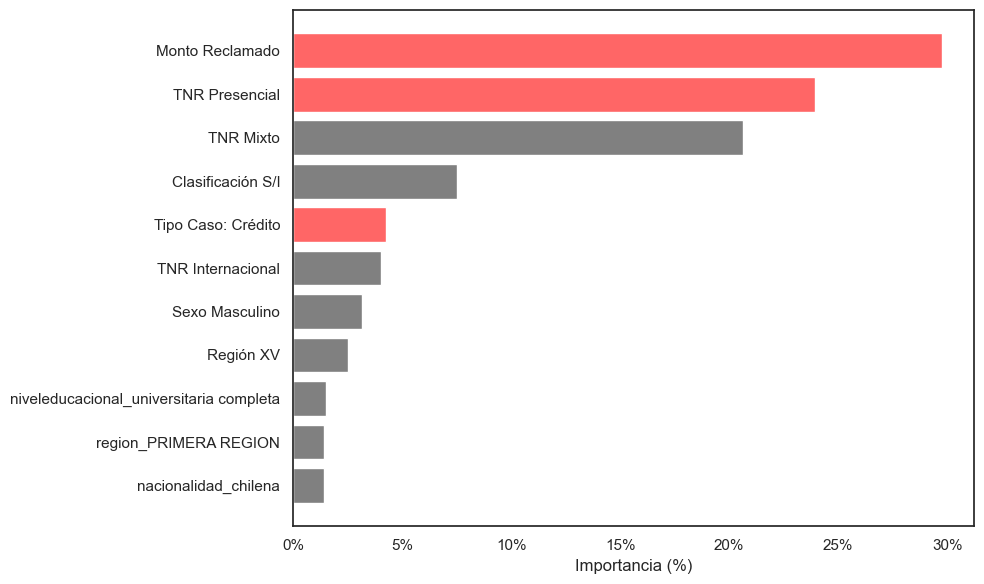

In [90]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Diccionario de mapeo: nombres originales a nombres nuevos
nombres_mapeo = {
    "montoreclamado": "Monto Reclamado",
    "clasificacion_tnr presencial": "TNR Presencial",
    "clasificacion_tnr mixto": "TNR Mixto",
    "clasificacion_s/i": "Clasificación S/I",
    "clasificacion_tnr internacional": "TNR Internacional",
    "tipocaso_T CREDITO": "Tipo Caso: Crédito",
    "sexo_masculino": "Sexo Masculino",
    "region_DECIMA QUINTA REGION": "Región XV",
    "nacionalidad_s/i": "Nacionalidad S/I"
}

# Crear una copia del DataFrame con los nombres actualizados
features_seleccionadas_xgb_grafico = features_seleccionadas_xgb.copy()
features_seleccionadas_xgb_grafico['feature'] = features_seleccionadas_xgb_grafico['feature'].replace(nombres_mapeo)

# Asegurarnos de que las importancias estén en proporción (entre 0 y 1)
features_seleccionadas_xgb_grafico['importance'] = (
    features_seleccionadas_xgb_grafico['importance'] / features_seleccionadas_xgb_grafico['importance'].sum()
)

# Definir las categorías que queremos en rojo con opacidad 0.6
categorias_rojas = ["Monto Reclamado", "TNR Presencial", "Tipo Caso: Crédito"]

# Asignar colores: rojo con opacidad para las categorías seleccionadas y gris para las demás
colors = ['red' if feature in categorias_rojas else 'gray' for feature in features_seleccionadas_xgb_grafico['feature']]

# Ajustar la opacidad de las barras rojas
colors = [(1, 0, 0, 0.6) if color == 'red' else (0.5, 0.5, 0.5, 1) for color in colors]  # RGBA formato

# Graficar las barras
plt.figure(figsize=(10, 6))
bars = plt.barh(features_seleccionadas_xgb_grafico['feature'], 
                features_seleccionadas_xgb_grafico['importance'], 
                color=colors)

plt.gca().invert_yaxis()  # Invertir el orden
plt.xlabel('Importancia (%)', fontsize=12)

# Formatear el eje X como porcentaje
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))

plt.tight_layout()
plt.savefig(path_directorio + 'Importancia_Relativa.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

In [91]:
selected_features = features_seleccionadas_xgb['feature'].tolist()

In [92]:
pd.set_option('display.max_rows', 10)

In [93]:
train_X_selected = train_X[selected_features]

In [94]:
test_X_selected = test_X[selected_features]

In [95]:
selected_features

['montoreclamado',
 'clasificacion_tnr presencial',
 'clasificacion_tnr mixto',
 'clasificacion_s/i',
 'tipocaso_T CREDITO',
 'clasificacion_tnr internacional',
 'sexo_masculino',
 'region_DECIMA QUINTA REGION',
 'niveleducacional_universitaria completa',
 'region_PRIMERA REGION',
 'nacionalidad_chilena']

## Best params Modelo XGBoost

In [96]:
#import xgboost as xgb
#from sklearn.model_selection import RandomizedSearchCV

In [97]:
# Crear el clasificador XGBoost
#clf = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')

# Definir el espacio de hiperparámetros para la búsqueda
#param_dist = {
#    'n_estimators': [100, 200, 300, 400, 500],
#    'learning_rate': [0.01, 0.05, 0.1, 0.2],
#    'max_depth': [3, 4, 5, 6, 7, 8, 9],
#    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
#    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
#    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
#    'reg_alpha': [0, 0.1, 0.5, 1.0],
#    'reg_lambda': [0, 0.1, 0.5, 1.0]
#}

In [98]:
# Configurar la búsqueda aleatoria con validación cruzada de 5 pliegues
#random_search = RandomizedSearchCV(
#    estimator=clf,
#    param_distributions=param_dist,
#    n_iter=50,  
#    scoring='f1', 
#    cv=5, 
#    verbose=2, 
#    random_state=42, 
#    n_jobs=-1
#)

# Ejecutar la búsqueda aleatoria
# random_search.fit(train_X_selected, train_y)

In [99]:
# Imprimir los mejores hiperparámetros encontrados
#print("Mejores hiperparámetros encontrados:")
#print(random_search.best_params_)

In [100]:
#{'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 0.8}

In [101]:
#params_xgboost = random_search.best_params_

### Interpretación Modelo

In [102]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

# Crear y entrenar el modelo
log_reg = LogisticRegression()
log_reg.fit(train_X_selected, train_y)

# Obtener coeficientes y el intercepto
coeficientes = log_reg.coef_[0]
intercepto = log_reg.intercept_[0]

# Calcular odds ratio
odds_ratios = np.exp(coeficientes)

# Crear un DataFrame con la información
tabla_coeficientes = pd.DataFrame({
    'Variable': train_X_selected.columns,
    'Coeficiente': coeficientes,
    'Odds Ratio': odds_ratios,
    'Interpretación': ["Incrementa" if coef > 0 else "Disminuye" for coef in coeficientes]
})

# Agregar el intercepto
intercepto_df = pd.DataFrame({
    'Variable': ['Intercepto'],
    'Coeficiente': [intercepto],
    'Odds Ratio': [np.exp(intercepto)],
    'Interpretación': ['Base del modelo']
})

# Concatenar las tablas
tabla_coeficientes = pd.concat([tabla_coeficientes, intercepto_df], ignore_index=True)

# Diccionario de mapeo: nombres originales a nombres nuevos
nombres_mapeo = {
    "montoreclamado": "Monto Reclamado",
    "clasificacion_tnr presencial": "TNR Presencial",
    "clasificacion_tnr mixto": "TNR Mixto",
    "clasificacion_s/i": "Clasificación S/I",
    "clasificacion_tnr internacional": "TNR Internacional",
    "tipocaso_T CREDITO": "Tipo Caso: Crédito",
    "sexo_masculino": "Sexo Masculino",
    "region_DECIMA QUINTA REGION": "Región XV"
}

# Aplicar el mapeo de nombres en la columna "Variable"
tabla_coeficientes['Variable'] = tabla_coeficientes['Variable'].replace(nombres_mapeo)

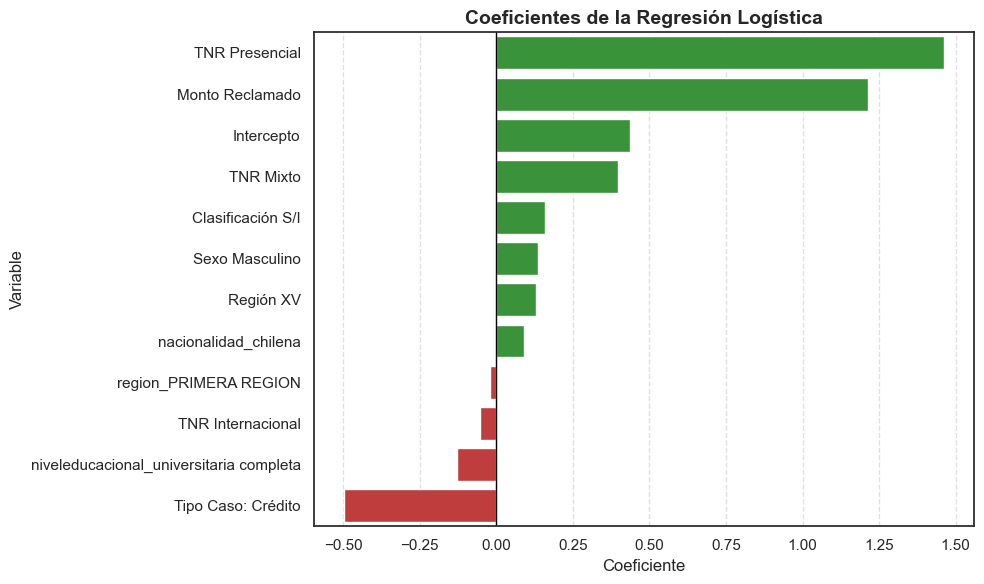

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear el gráfico de barras horizontal
plt.figure(figsize=(10, 6))

# Ordenar por magnitud de los coeficientes
tabla_coeficientes_ordenada = tabla_coeficientes.sort_values(by='Coeficiente', ascending=False)

# Crear el gráfico
sns.barplot(
    x='Coeficiente', 
    y='Variable', 
    data=tabla_coeficientes_ordenada,
    palette=["#2ca02c" if coef > 0 else "#d62728" for coef in tabla_coeficientes_ordenada['Coeficiente']]
)

# Agregar líneas de referencia
plt.axvline(0, color='black', linewidth=1)

# Personalización
plt.title('Coeficientes de la Regresión Logística', fontsize=14, weight='bold')
plt.xlabel('Coeficiente')
plt.ylabel('Variable')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

## Train XGBoost

In [104]:
selected_features

['montoreclamado',
 'clasificacion_tnr presencial',
 'clasificacion_tnr mixto',
 'clasificacion_s/i',
 'tipocaso_T CREDITO',
 'clasificacion_tnr internacional',
 'sexo_masculino',
 'region_DECIMA QUINTA REGION',
 'niveleducacional_universitaria completa',
 'region_PRIMERA REGION',
 'nacionalidad_chilena']

In [105]:
train_X_selected.info()

<class 'pandas.core.frame.DataFrame'>
Index: 879276 entries, 1470274 to 703185
Data columns (total 11 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   montoreclamado                           879276 non-null  float64
 1   clasificacion_tnr presencial             879276 non-null  float64
 2   clasificacion_tnr mixto                  879276 non-null  float64
 3   clasificacion_s/i                        879276 non-null  float64
 4   tipocaso_T CREDITO                       879276 non-null  float64
 5   clasificacion_tnr internacional          879276 non-null  float64
 6   sexo_masculino                           879276 non-null  float64
 7   region_DECIMA QUINTA REGION              879276 non-null  float64
 8   niveleducacional_universitaria completa  879276 non-null  float64
 9   region_PRIMERA REGION                    879276 non-null  float64
 10  nacionalidad_chilena           

In [106]:
params_xgboost = {
    'subsample': 0.6,
    'reg_lambda': 0.5,
    'reg_alpha': 0,
    'n_estimators': 500,
    'max_depth': 9,
    'learning_rate': 0.2,
    'gamma': 0.3,
    'colsample_bytree': 0.8
}

# Crear el clasificador XGBoost
best_model_xgboost = xgb.XGBClassifier(**params_xgboost)
# Entrenar el modelo
best_model_xgboost.fit(train_X_selected, train_y)

guardar_modelo(best_model_xgboost, path_directorio + 'best_model_xgboost.pkl')

Modelo guardado en: ./best_model_xgboost.pkl


In [107]:
from sklearn.metrics import accuracy_score

# Asumiendo que test_X_selected y test_y están disponibles
pred_values_xg = best_model_xgboost.predict(test_X_selected)

# Asumiendo que test_X_selected y test_y están disponibles
pred_values_xg_proba = best_model_xgboost.predict_proba(test_X_selected)

In [108]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
conf_matrix = confusion_matrix(test_y, pred_values_xg)
print(classification_report(test_y, pred_values_xg))

              precision    recall  f1-score   support

           0       0.91      0.77      0.83     86789
           1       0.86      0.95      0.90    133030

    accuracy                           0.88    219819
   macro avg       0.89      0.86      0.87    219819
weighted avg       0.88      0.88      0.88    219819



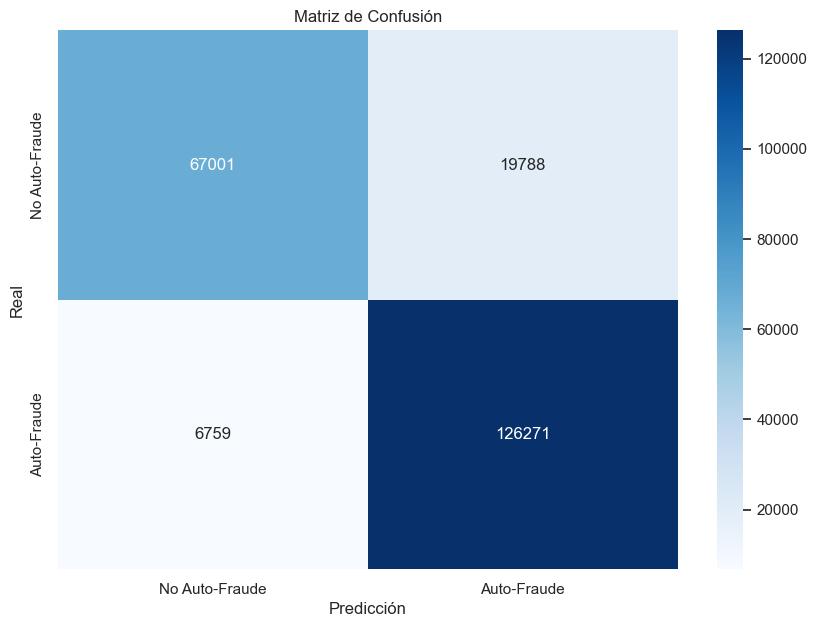

In [109]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Auto-Fraude', 'Auto-Fraude'], yticklabels=['No Auto-Fraude', 'Auto-Fraude'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.savefig(path_directorio+'Matriz_de_confusion_XG.png', transparent=True,  bbox_inches='tight', dpi=300, pad_inches=0.1)
plt.show()
plt.close()

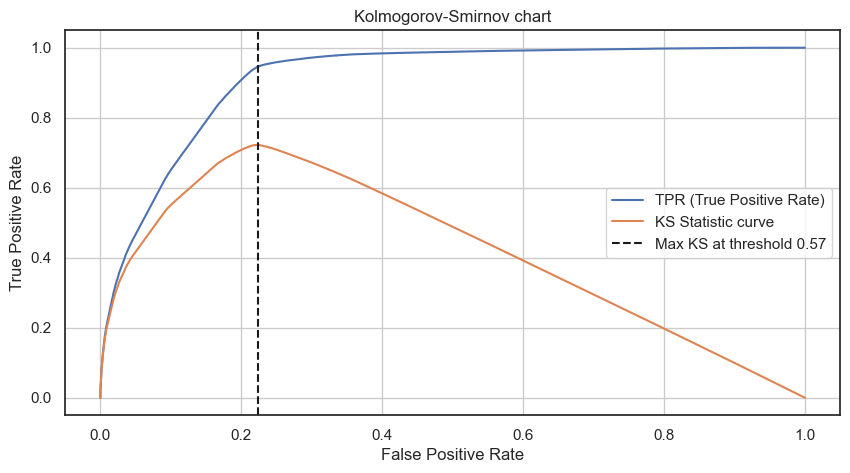

KS Statistic: 0.7226


In [110]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Supongamos que 'probabilidades' contiene las probabilidades de la clase 1
fpr, tpr, thresholds = roc_curve(test_y, pred_values_xg_proba[:,1])

# Calcular el KS
ks_statistic = max(tpr - fpr)
ks_threshold = thresholds[np.argmax(tpr - fpr)]

# Graficar el KS
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label='TPR (True Positive Rate)')
plt.plot(fpr, tpr - fpr, label='KS Statistic curve')
plt.axvline(x=fpr[np.argmax(tpr - fpr)], color='k', linestyle='--', label=f'Max KS at threshold {ks_threshold:.2f}')
plt.title('Kolmogorov-Smirnov chart')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig(path_directorio+'KS_XG.png', transparent=True,  bbox_inches='tight', dpi=300, pad_inches=0.1)
plt.show()
plt.close()

print(f"KS Statistic: {ks_statistic:.4f}")

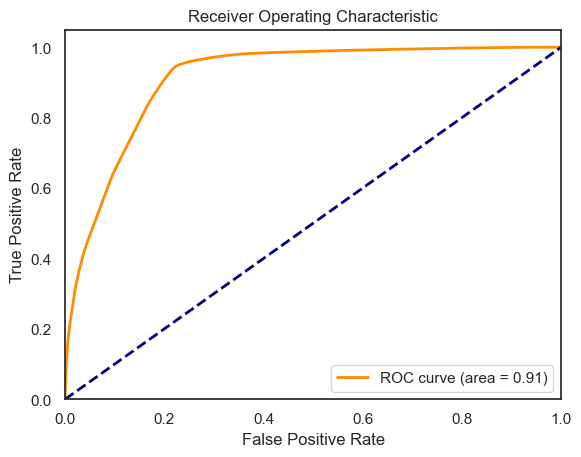

In [112]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Supongamos que 'predictions' son las probabilidades de la clase positiva
# y 'test_y' son las etiquetas verdaderas
fpr, tpr, thresholds = roc_curve(test_y, pred_values_xg_proba[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig(path_directorio+'Curva_ROC_XG.png', transparent=True,  bbox_inches='tight', dpi=300, pad_inches=0.1)
plt.show()
plt.close()

# Optimización Punto Corte

In [113]:
test_X_real = test_X_selected.copy()


# Cruzar `test_X_selected` con `df_entrenamiento_final` para agregar `montoreclamado` como `montoreclamado_real`
test_X_selected_final = test_X_selected.join(
    df_entrenamiento_final[['montoreclamado']].rename(columns={'montoreclamado': 'montoreclamado_real'}),
    how='left'
)

test_X_selected_final['prob'] = pred_values_xg_proba[:, 1]
test_X_selected_final['real_class'] = test_y

In [114]:
import numpy as np
import matplotlib.pyplot as plt

# Asumiendo que `test_y` está representado dentro de `test_X_selected_final`
# Por ejemplo, si tienes una columna como `real_class` que representa la etiqueta verdadera
test_y = test_X_selected_final['real_class'].values  # Reemplaza por la columna adecuada
pred_proba = test_X_selected_final['prob'].values
Monto_Reclamado = test_X_selected_final['montoreclamado_real'].values
Valor_Atencion = 56000

# Definir función para calcular costos y beneficios
def calculate_custom_cost(test_y, pred_proba, Monto_Reclamado, Valor_Atencion, thresholds):
    optimal_threshold = None
    optimal_cost = float('-inf')
    costs = []

    for threshold in thresholds:
        # Predicciones con el threshold actual
        pred_class = (pred_proba >= threshold).astype(int)

        # Calcular TP, TN, FP, FN
        tp = (test_y == 1) & (pred_class == 1)
        tn = (test_y == 0) & (pred_class == 0)
        fp = (test_y == 0) & (pred_class == 1)
        fn = (test_y == 1) & (pred_class == 0)

        # Calcular costos y beneficios por fila
        cost_tp = np.sum(tp * Monto_Reclamado)
        cost_tn = np.sum(tn * 0)  # Beneficio de TN es 0
        cost_fp = np.sum(fp * Valor_Atencion)
        cost_fn = np.sum(fn * (Monto_Reclamado + Valor_Atencion))

        # Costo total
        total_cost = cost_tp - cost_fp - cost_fn
        costs.append(total_cost)

        # Actualizar threshold óptimo
        if total_cost > optimal_cost:
            optimal_cost = total_cost
            optimal_threshold = threshold

    return optimal_threshold, optimal_cost, costs

# Generar thresholds basados en probabilidades predichas
thresholds = np.linspace(0, 1, 100)

# Optimización del threshold
optimal_threshold, optimal_cost, costs = calculate_custom_cost(
    test_y,
    pred_proba,
    Monto_Reclamado,
    Valor_Atencion,
    thresholds
)

# Mostrar el threshold óptimo
print(f"Threshold Óptimo: {optimal_threshold:.4f}")
print(f"Costo Óptimo: {optimal_cost:.2f}")

Threshold Óptimo: 0.1212
Costo Óptimo: 74860938331.00


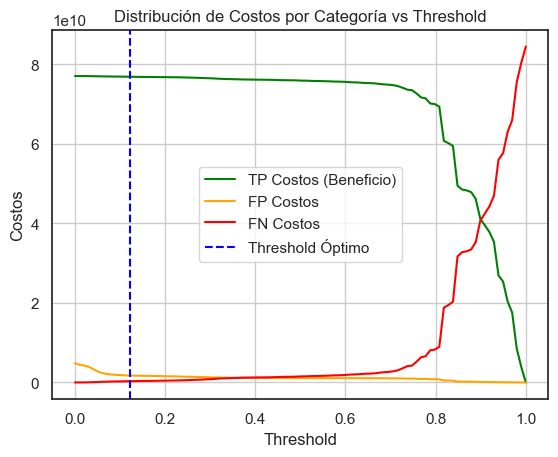

In [115]:
def calculate_cost_components(test_y, pred_proba, Monto_Reclamado, Valor_Atencion, thresholds):
    tp_costs, fp_costs, fn_costs = [], [], []

    for threshold in thresholds:
        pred_class = (pred_proba >= threshold).astype(int)

        tp = (test_y == 1) & (pred_class == 1)
        fp = (test_y == 0) & (pred_class == 1)
        fn = (test_y == 1) & (pred_class == 0)

        tp_costs.append(np.sum(tp * Monto_Reclamado))
        fp_costs.append(np.sum(fp * Valor_Atencion))
        fn_costs.append(np.sum(fn * (Monto_Reclamado + Valor_Atencion)))

    return tp_costs, fp_costs, fn_costs

# Calcular los componentes de costo
tp_costs, fp_costs, fn_costs = calculate_cost_components(test_y, pred_proba, Monto_Reclamado, Valor_Atencion, thresholds)

# Graficar los componentes de costo
plt.figure()
plt.plot(thresholds, tp_costs, label="TP Costos (Beneficio)", color="green")
plt.plot(thresholds, fp_costs, label="FP Costos", color="orange")
plt.plot(thresholds, fn_costs, label="FN Costos", color="red")
plt.axvline(x=optimal_threshold, color='blue', linestyle='--', label="Threshold Óptimo")
plt.xlabel("Threshold")
plt.ylabel("Costos")
plt.title("Distribución de Costos por Categoría vs Threshold")
plt.legend()
plt.grid()
plt.show()


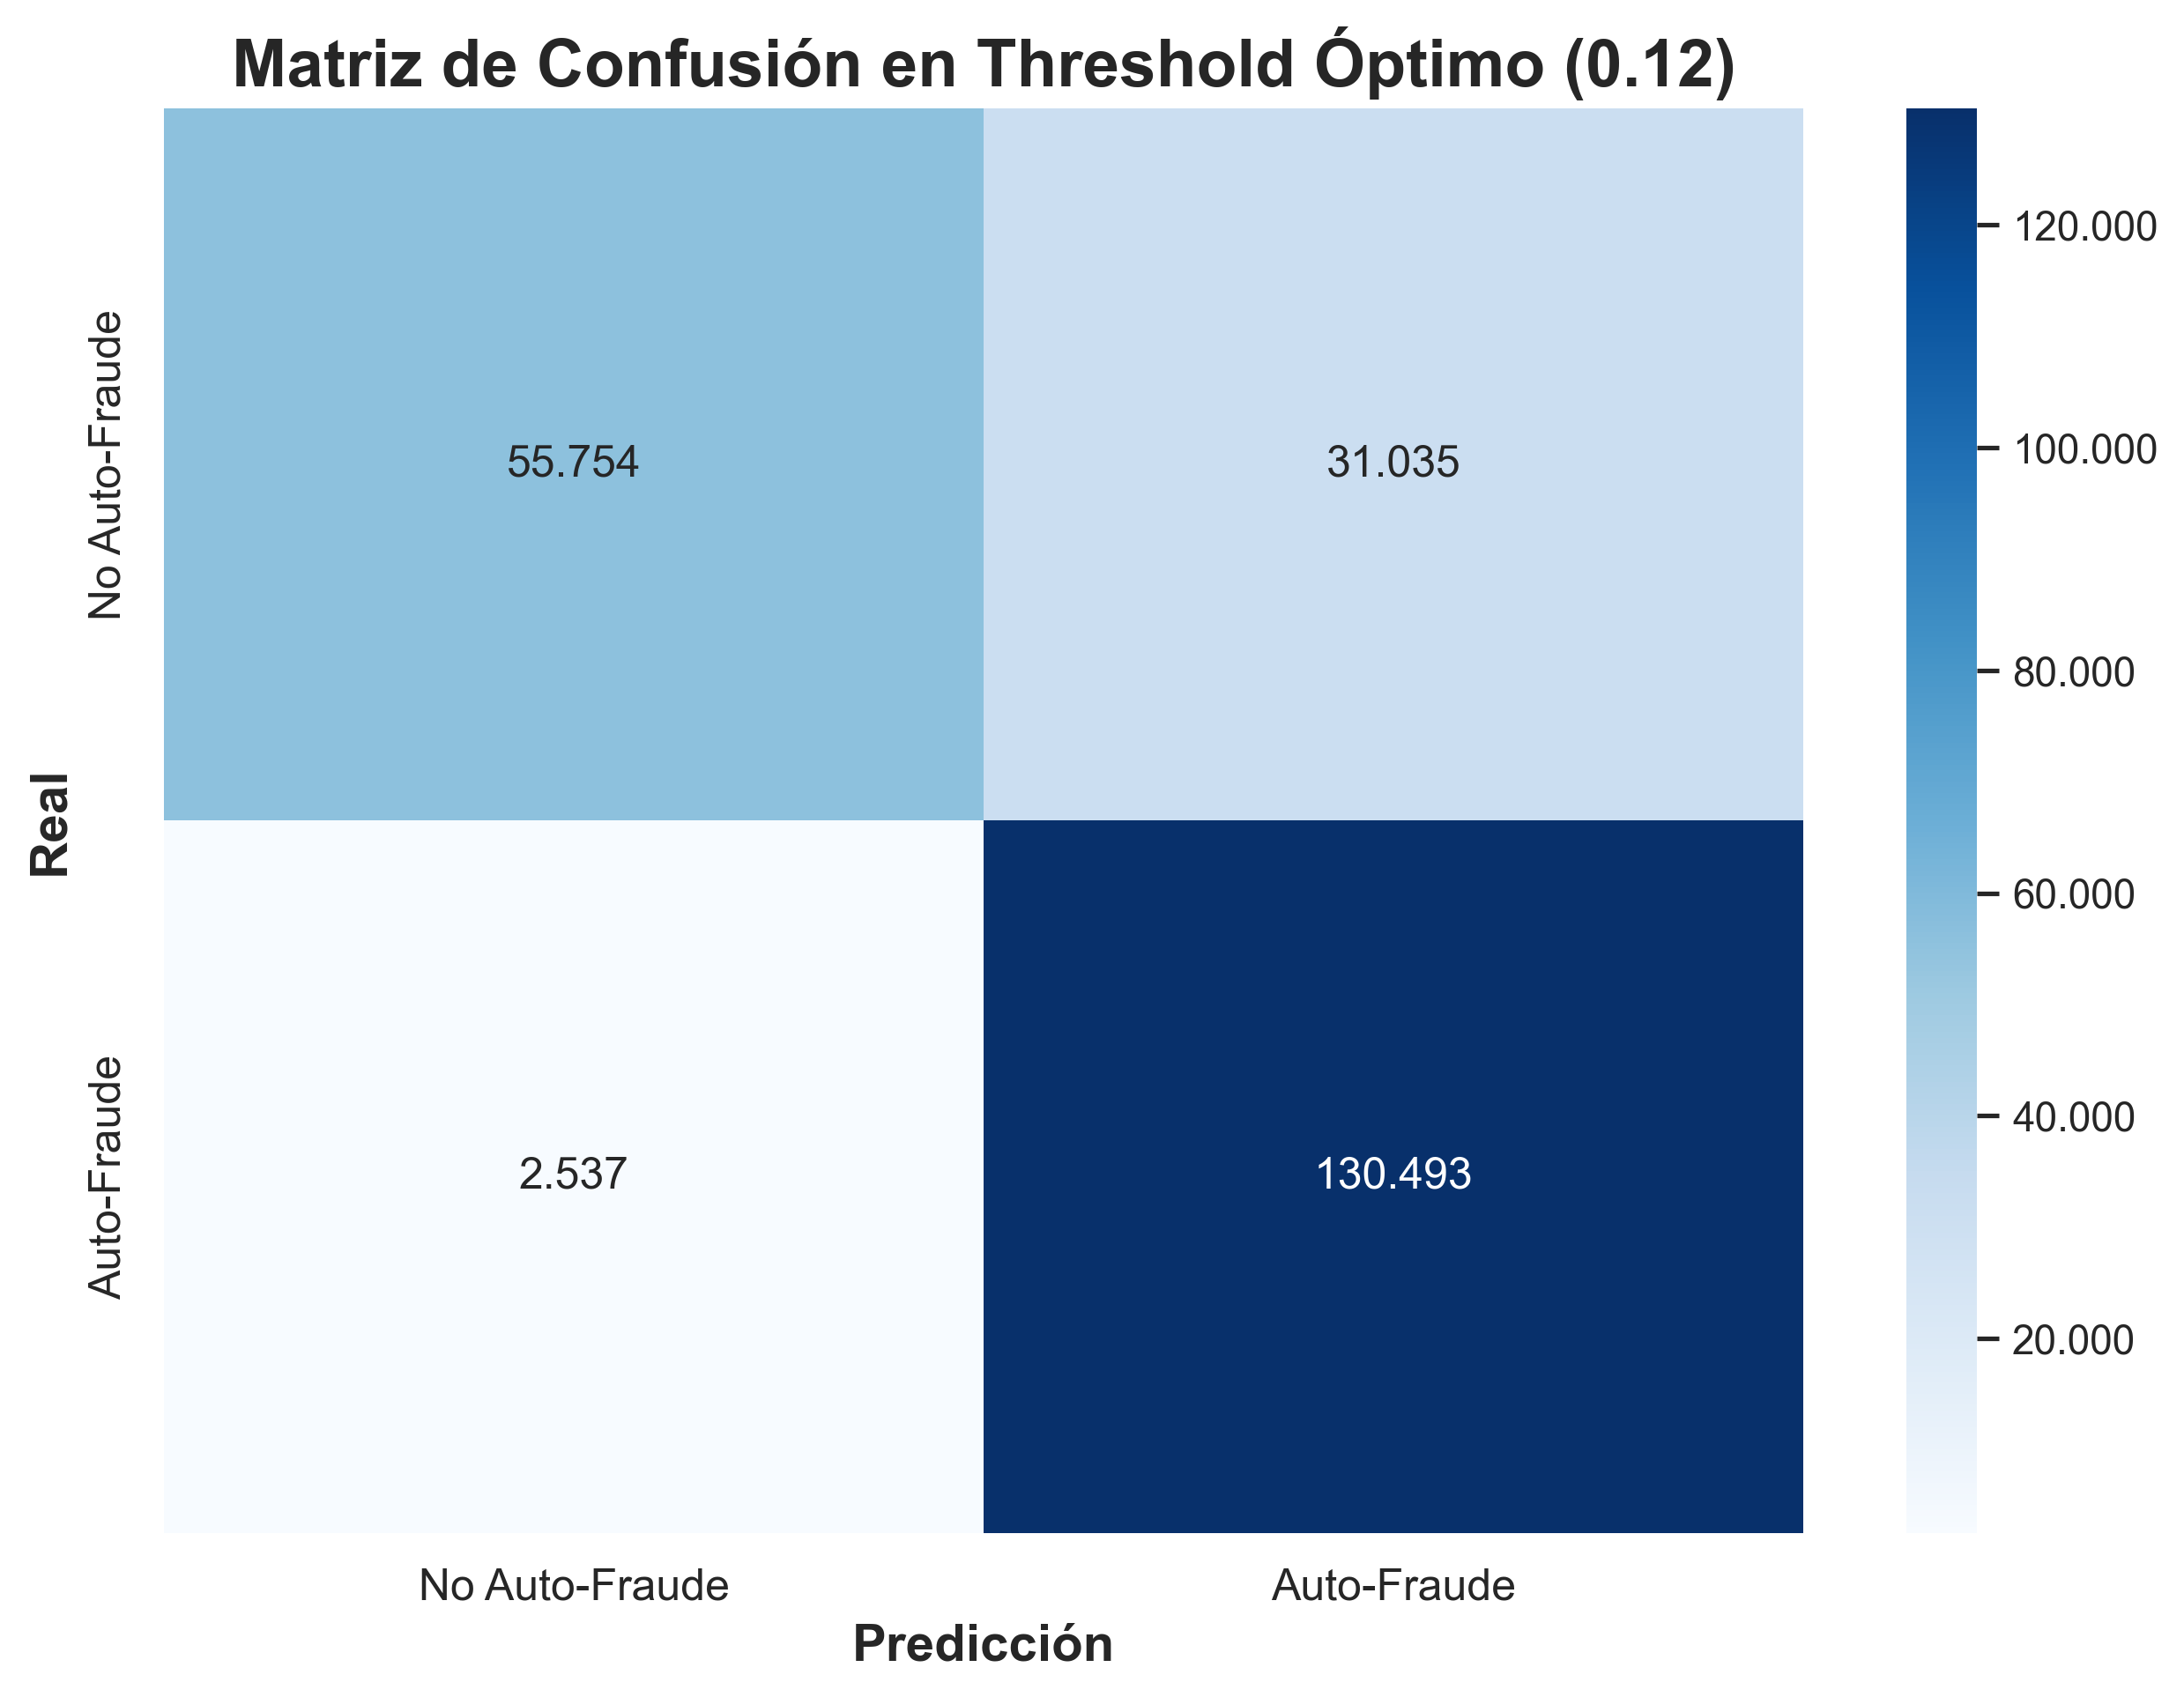

Gráfico guardado en: ./Matriz C.png


In [116]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from matplotlib.ticker import FuncFormatter

# Función para formatear números con puntos como separadores de miles
def format_with_dots(x, pos):
    return f"{int(x):,}".replace(",", ".")

# Definir pred_class_optimal basándote en pred_proba y optimal_threshold
pred_class_optimal = (pred_proba >= optimal_threshold).astype(int)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(test_y, pred_class_optimal)

# Configurar el gráfico con seaborn
plt.figure(figsize=(10, 7), dpi=300)  # Ajustar tamaño y DPI
ax = sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt='d',  # Formato con números enteros
    cmap='Blues', 
    xticklabels=['No Auto-Fraude', 'Auto-Fraude'], 
    yticklabels=['No Auto-Fraude', 'Auto-Fraude'],
    cbar_kws={'format': FuncFormatter(format_with_dots)}  # Formato del colorbar con puntos
)

# Personalizar etiquetas y título
plt.title(f'Matriz de Confusión en Threshold Óptimo ({optimal_threshold:.2f})', fontsize=18, fontweight='bold')
plt.xlabel('Predicción', fontsize=14, fontweight='bold')
plt.ylabel('Real', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Reemplazar números en las celdas con puntos como separadores de miles
for text in ax.texts:
    value = text.get_text()
    if value.isdigit():  # Asegurarse de que el texto es un número
        text.set_text(f"{int(value):,}".replace(",", "."))

# Guardar el gráfico en alta calidad
output_path = path_directorio + 'Matriz C.png'
plt.savefig(output_path, transparent=True, bbox_inches='tight', dpi=300, pad_inches=0.1)

# Mostrar el gráfico
plt.show()
plt.close()

print(f"Gráfico guardado en: {output_path}")

In [117]:
import numpy as np

# Supongamos estos valores de costos/beneficios
monto_reclamado_promedio = 700000  # CLP (promedio de monto reclamado)
costo_gestion = 56000  # CLP (costo por gestionar un caso)

# Obtener valores de la matriz de confusión
tn, fp, fn, tp = conf_matrix.ravel()

# Calcular costos y beneficios
beneficio_tp = tp * monto_reclamado_promedio  # Beneficio por detectar correctamente fraudes
costo_fn = fn * (monto_reclamado_promedio + costo_gestion)  # Pérdida por no detectar fraudes
costo_fp = fp * costo_gestion  # Costo por gestionar casos no fraude
beneficio_tn = 0  # TN no aporta beneficios ni costos

# Beneficio total
beneficio_total = beneficio_tp - costo_fn - costo_fp

# Mostrar los resultados
print(f"Casos en la matriz de confusión:")
print(f"  Verdaderos Negativos (TN): {tn:,}")
print(f"  Falsos Positivos (FP): {fp:,}")
print(f"  Falsos Negativos (FN): {fn:,}")
print(f"  Verdaderos Positivos (TP): {tp:,}")
print()
print(f"Resultados financieros:")
print(f"  Beneficio por TP: {beneficio_tp:,} CLP")
print(f"  Costo por FN: {costo_fn:,} CLP")
print(f"  Costo por FP: {costo_fp:,} CLP")
print(f"  Beneficio Total: {beneficio_total:,} CLP")


Casos en la matriz de confusión:
  Verdaderos Negativos (TN): 55,754
  Falsos Positivos (FP): 31,035
  Falsos Negativos (FN): 2,537
  Verdaderos Positivos (TP): 130,493

Resultados financieros:
  Beneficio por TP: 91,345,100,000 CLP
  Costo por FN: 1,917,972,000 CLP
  Costo por FP: 1,737,960,000 CLP
  Beneficio Total: 87,689,168,000 CLP


In [119]:
optimal_threshold=0.63

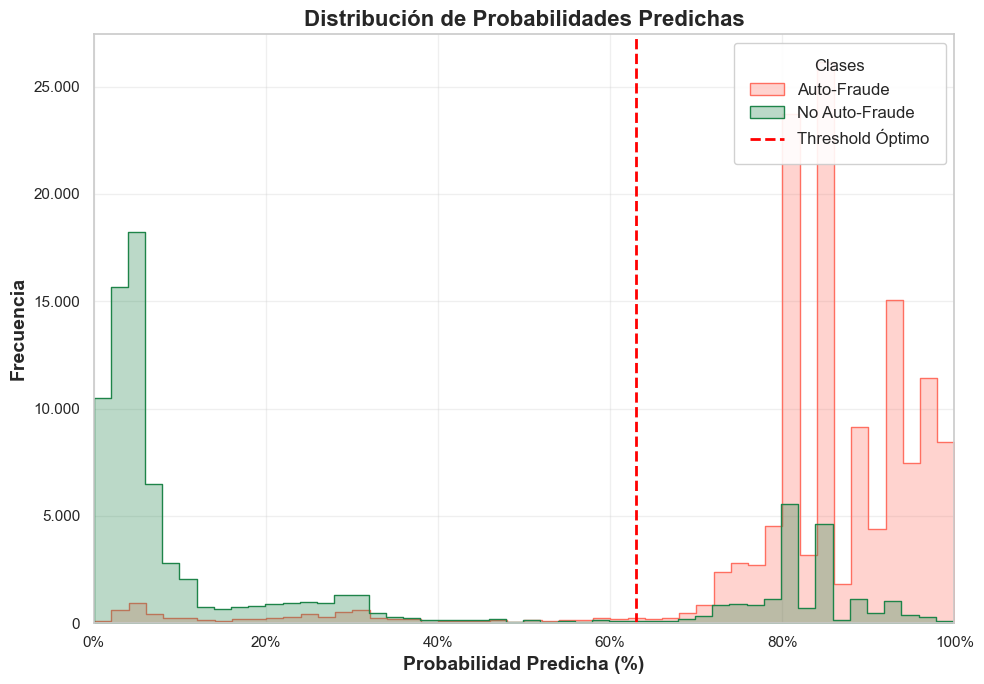

Gráfico guardado en: C:/Users/jmend/OneDrive/Escritorio/Magister/Capstone/Distribucion_Probabilidades_Predichas.png


In [120]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Definir el directorio y nombre del archivo
path_directorio = 'C:/Users/jmend/OneDrive/Escritorio/Magister/Capstone/'
nombre_archivo = 'Distribucion_Probabilidades_Predichas.png'

# Función para formatear números con puntos como separadores de miles
def format_with_dots(x, pos):
    return f"{int(x):,}".replace(",", ".")

# Función para convertir las probabilidades en porcentajes
def format_as_percentage(x, pos):
    return f"{x*100:.0f}%"

# Configuración del estilo
sns.set(style="whitegrid")
plt.figure(figsize=(10, 7))

# Crear el histograma de clase positiva y negativa con colores personalizados y opacidad
sns.histplot(pred_proba[test_y == 1], bins=50, color="#ff6f61", label="Auto-Fraude", kde=False, element="step", alpha=0.3)  # Rojo con opacidad
sns.histplot(pred_proba[test_y == 0], bins=50, color="#1e8449", label="No Auto-Fraude", kde=False, element="step", alpha=0.3)  # Verde oscuro con opacidad

# Línea del threshold óptimo
plt.axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=2, label="Threshold Óptimo")

# Ajustar el rango del eje X
plt.xlim(0, 1)  # Probabilidades van de 0 a 1

# Personalización de etiquetas y título
plt.xlabel("Probabilidad Predicha (%)", fontsize=14, fontweight='bold')
plt.ylabel("Frecuencia", fontsize=14, fontweight='bold')
plt.title("Distribución de Probabilidades Predichas", fontsize=16, fontweight='bold')

# Formatear los ejes
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_with_dots))  # Formatear eje izquierdo
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_as_percentage))  # Formatear eje inferior

# Personalización de leyenda
plt.legend(title="Clases", title_fontsize=12, fontsize=12, loc="upper right", frameon=True, framealpha=0.9, borderpad=1)

# Ajustar el diseño para evitar superposición
plt.tight_layout()

# Reducir visibilidad de la grilla
plt.grid(visible=True, alpha=0.3)  # Alpha ajusta la transparencia de la grilla

# Guardar el gráfico en alta calidad
output_path = path_directorio + nombre_archivo
plt.savefig(output_path, transparent=True, bbox_inches='tight', dpi=300, pad_inches=0.1)

# Mostrar el gráfico
plt.show()
plt.close()

print(f"Gráfico guardado en: {output_path}")


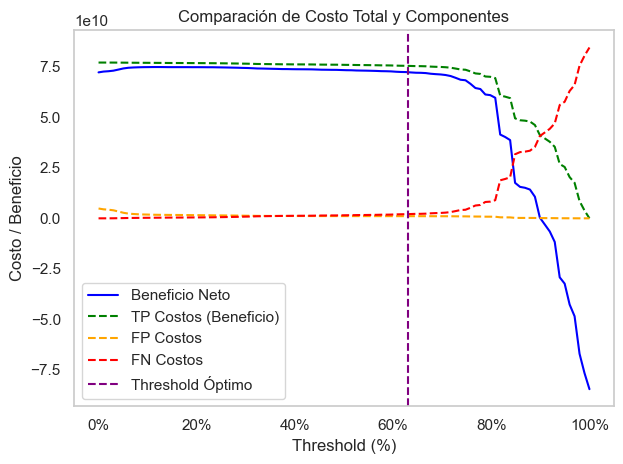

Gráfico guardado en: C:/Users/jmend/OneDrive/Escritorio/Magister/Capstone/Comparacion_Costo_Total_Componentes.png


In [121]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Función para convertir valores en porcentajes
def format_as_percentage(x, pos):
    return f"{x*100:.0f}%"

# Ruta base para guardar el archivo
output_path = path_directorio + 'Comparacion_Costo_Total_Componentes.png'

# Crear la figura y los gráficos
plt.figure()
plt.plot(thresholds, costs, label="Beneficio Neto", color="blue")
plt.plot(thresholds, tp_costs, label="TP Costos (Beneficio)", color="green", linestyle="--")
plt.plot(thresholds, fp_costs, label="FP Costos", color="orange", linestyle="--")
plt.plot(thresholds, fn_costs, label="FN Costos", color="red", linestyle="--")
plt.axvline(x=optimal_threshold, color='purple', linestyle='--', label="Threshold Óptimo")

# Etiquetas y título
plt.xlabel("Threshold (%)")
plt.ylabel("Costo / Beneficio")
plt.title("Comparación de Costo Total y Componentes")

# Formatear el eje X en porcentaje
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_as_percentage))

# Leyenda y grilla
plt.legend()
plt.grid()

# Ajustar diseño para evitar superposición
plt.tight_layout()

# Guardar el gráfico en alta calidad
plt.savefig(output_path, transparent=True, bbox_inches='tight', dpi=300, pad_inches=0.1)

# Mostrar el gráfico
plt.show()

print(f"Gráfico guardado en: {output_path}")

In [136]:
df_final_limpio[0:1]

,rutreclamante,idcaso,fechacreacioncaso,montoreclamado,edad,comuna,ciudad,cantidaddehijos,cantidatrxdebitoultimomes,promediotrxdebitoultimomes,montototaldebitoultimomes,promediomontototaldebitoultimomes,cantidatrxdebitoultimos3meses,promediotrxdebitoultimos3meses,montototaldebitoultimos3meses,promediomontototaldebitoultimos3meses,cantidaddepositosultimomes,promediodepositosultimomes,montototaldepositosultimomes,promediomontototaldepositosultimomes,cantidaddepositosultimos3meses,promediodepositosultimos3meses,montototaldepositosultimos3meses,promediomontototaldepositosultimos3meses,cantidadabonosultimomes,promedioabonosultimomes,montototalabonosultimomes,promediomontototalabonosultimomes,cantidadabonosultimos3meses,promedioabonosultimos3meses,montototalabonosultimos3meses,promediomontototalabonosultimos3meses,cantidadgirosultimomes,promediogirosultimomes,montototalgirosultimomes,promediomontototalgirosultimomes,cantidadgirosultimos3meses,promediogirosultimos3meses,montototalgirosultimos3meses,promediomontototalgirosultimos3meses,distinctcantidadproductodeuda,saldodeudavigente,tienesaldodeudamora1,tienesaldodeudamora2,tienesaldodeudamora3,tienesaldodeudacastigada,saldodeudavigentecredito,porcentajedeudacredito,tienecredito,saldodeudavigentehipotecario,porcentajedeudahipotecario,tienehipotecario,distrutstransfconreclamospagadosult6meses,cantidaddetransfarutsconreclamospagadosult6meses,label,clasificacion_s/i,clasificacion_tnr internacional,clasificacion_tnr mixto,clasificacion_tnr no presencial,clasificacion_tnr presencial,estocivil_casado,estocivil_conviviente civil,estocivil_divorciado sin disolucion de vinculo,estocivil_s/i,estocivil_separado,estocivil_soltero,estocivil_viudo,nacionalidad_chilena,nacionalidad_extranjera,nacionalidad_extranjera residente,nacionalidad_nacionalizado,nacionalidad_s/i,sexo_femenino,sexo_masculino,sexo_s/i,niveleducacional_basico/primario,niveleducacional_medio/secundario,niveleducacional_postgrado,niveleducacional_s/i,niveleducacional_tecnico profesional completo,niveleducacional_tecnico profesional incompleto,niveleducacional_universitaria completa,niveleducacional_universitaria incompleta,tipocaso_T CREDITO,tipocaso_TNR,canalingreso_Gerencias Banco,canalingreso_Medios de Comunicacion,canalingreso_Mesa Postventa Mayorista,canalingreso_Organismo Contralor,canalingreso_RR. SS.,canalingreso_Sucursal,canalingreso_Telefonia,canalingreso_Web Contactenos,segmentocliente_0,segmentocliente_CHILENO EN EL EXTERIOR,segmentocliente_CORPORACIONES,segmentocliente_EMPRESAS,segmentocliente_GRANDES EMPRESAS,segmentocliente_MICROEMPRESA AGRICOLA,segmentocliente_MICROEMPRESA NO AGRICOLA,segmentocliente_OSC - INST SIN FINES DE LUCRO,segmentocliente_PEQUENA EMPRESA AGRICOLA,segmentocliente_PEQUENA NO AGRICOLA,segmentocliente_PERSONAS,segmentocliente_SECTOR CENTRALIZADO,segmentocliente_SIN SEGMENTO,segmentocliente_SIN SEGMENTO MICRO,segmentocliente_SOCIO DE MICROEMPRESA,segmentocliente_SOCIO DE PEQUENA EMPRESA,region_CUARTA REGION,region_DECIMA CUARTA REGION,region_DECIMA QUINTA REGION,region_DECIMA REGION,region_DECIMA SEXTA REGION,region_DUODECIMA REGION,region_NOVENA REGION,region_OCTAVA REGION,region_PRIMERA REGION,region_QUINTA REGION,region_REGION METROPOLITANA,region_SEGUNDA REGION,region_SEPTIMA REGION,region_SEXTA REGION,region_SinRegion,region_TERCERA REGION,region_UNDECIMA REGION
3,186145526,5004V00001UbrjkQAB,2023-11-28,790000.0,29,CERRO NAVIA,SANTIAGO,0,22,1.0,98589,4481,81,1.0,515705,6367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fal

In [137]:
test_X_selected_final[0:3]

,montoreclamado,clasificacion_tnr presencial,clasificacion_tnr mixto,clasificacion_s/i,tipocaso_T CREDITO,clasificacion_tnr internacional,sexo_masculino,region_DECIMA QUINTA REGION,niveleducacional_universitaria completa,region_PRIMERA REGION,nacionalidad_chilena,montoreclamado_real,prob,real_class
173337,-1.192131,-1.445284,-0.228913,-0.08309,-0.08811,-0.466407,0.96262,-0.110684,-0.148511,-0.121357,0.225108,18720.0,0.030937,0
1120833,-0.062331,0.691905,-0.228913,-0.08309,-0.08811,-0.466407,0.96262,-0.110684,-0.148511,-0.121357,0.225108,400000.0,0.847437,0
431516,-0.062331,0.691905,-0.228913,-0.08309,-0.08811,-0.466407,0.96262,-0.110684,-0.148511,-0.121357,0.225108,400000.0,0.847437,1


In [141]:
# Cruzar por índice y agregar las columnas deseadas
test_X_selected_final_output_estebam = test_X_selected_final.join(df_final_limpio[['idcaso', 'rutreclamante']])

ValueError: columns overlap but no suffix specified: Index(['idcaso', 'rutreclamante'], dtype='object')

In [ ]:
test_X_selected_final.to_csv(path_directorio + 'test_X_selected_final.csv', index=False,decimal=",",sep=";")

: 

# Shap Value

In [122]:
import shap
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

ModuleNotFoundError: No module named 'shap'

In [ ]:
selected_features

In [ ]:
selected_features

In [ ]:
train_X

In [ ]:
df_shap = train_X[selected_features]

In [ ]:
# Asumiendo que train_X es tu DataFrame con las características de entrenamiento
import pandas as pd

# Muestrear un subconjunto de datos (por ejemplo, 1000 filas)
train_X_sampled = df_shap.sample(n=3000, random_state=30)

# Verifica el tamaño de la muestra
print(f"Tamaño de train_X_sampled: {train_X_sampled.shape}")

In [ ]:
# Calcular los valores SHAP para el modelo y los datos
explainer = shap.Explainer(best_model_xgboost, train_X_sampled)
shap_values = explainer(train_X_sampled)

In [ ]:
# Crear gráfico de importancia global
shap.summary_plot(shap_values, train_X_sampled)

In [ ]:
import shap
import matplotlib.pyplot as plt
import os

# Seleccionar una instancia específica por índice
indice_caso = 360  # Índice en la muestra
indice_real = train_X_sampled.iloc[indice_caso].name  # Índice real del dataset original
print(f"Índice real de la muestra seleccionada: {indice_real}")

# Obtener los valores originales directamente desde df_entrenamiento_final
valores_originales = df_entrenamiento_final.loc[indice_real]



# Variables de interés
variables_a_incluir = [
    'clasificacion_tnr presencial', 'montoreclamado',
    'clasificacion_tnr internacional', 'sexo_masculino',
    'tipocaso_T CREDITO', 'clasificacion_tnr mixto',
    'region_DECIMA QUINTA REGION', 'clasificacion_s/i'
]

# Validar que las columnas están presentes en train_X_sampled
assert all(var in train_X_sampled.columns for var in variables_a_incluir), "Algunas variables no están en train_X_sampled"

# Extraer los índices correspondientes
indices_a_incluir = [train_X_sampled.columns.get_loc(var) for var in variables_a_incluir]

# Filtrar valores SHAP y datos originales
shap_values_filtrados = shap_values[indice_caso].values[indices_a_incluir]
valores_originales_filtrados = valores_originales[variables_a_incluir]

# Aplicar el mapeo de nombres
feature_names_mapeadas = [nombres_mapeo.get(var, var) for var in variables_a_incluir]

# Validar las dimensiones de los valores SHAP y datos originales
assert len(shap_values_filtrados) == len(valores_originales_filtrados), "Desalineación entre SHAP y valores originales"

# Crear el waterfall plot
plt.figure()
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_filtrados,
        base_values=shap_values[indice_caso].base_values,
        data=valores_originales_filtrados.values,
        feature_names=feature_names_mapeadas
    ),
    max_display=10
)

# Guardar el gráfico
output_path = os.path.join(path_directorio, 'SHAP_Waterfall_Top10.png')
plt.savefig(output_path, transparent=True, bbox_inches='tight', dpi=300, pad_inches=0.1)
plt.close()
print(f"Gráfico guardado en: {output_path}")

## PyCaret - Buscando el mejor Modelo

In [ ]:
selected_features

In [ ]:
#import pandas as pd
#from pycaret.classification import *

In [ ]:
#df_pycaret = df_final_modelo.copy()

In [ ]:
#import pandas as pd
#from pycaret.classification import setup, compare_models, tune_model, evaluate_model, predict_model

In [ ]:
#X = df_pycaret.drop(columns=['label'])
#y = df_pycaret['label']
#data = pd.concat([X, y], axis=1)

In [ ]:
#clf = setup(data, target='label', session_id=123, verbose=False)

In [ ]:
#import pandas as pd
#from pycaret.classification import *
#
## Supongamos que ya tienes df definido en tu entorno
## Si no, carga tu dataframe desde un CSV (comenta esta línea si ya tienes df)
## df = pd.read_csv('Capstone.csv')
#
## Separar las características y el objetivo
## Asumimos que 'label' es la columna objetivo
#df['label'] = df['label'].replace({0: 'No Auto-Fraude', 1: 'Auto-Fraude'})
#
#
## Concatenar las características y el objetivo para PyCaret
#
## Comparar todos los modelos y seleccionar el mejor
#best_model = compare_models()
#
## Tunear el mejor modelo
#tuned_model = tune_model(best_model)
#
## Evaluar el modelo tunado
#evaluate_model(tuned_model)
#
## Predecir en el conjunto de prueba
#predictions = predict_model(tuned_model, data=data)
#


In [ ]:
#best_model

In [ ]:
# Visualizar la matriz de confusión usando seaborn
#import seaborn as sns
#import matplotlib.pyplot as plt
#
#plt.figure(figsize=(10, 7))
#sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Auto-Fraude', 'Auto-Fraude'], yticklabels=['No Auto-Fraude', 'Auto-Fraude'])
#
## Personalizar el gráfico
#plt.title('Matriz de Confusión')
#plt.xlabel('Predicción')
#plt.ylabel('Real')
#plt.show()

# Prediccion Capstone

In [ ]:
# Definir la fecha límite
fecha_inicio_pred = '2024-02-01'
df_pred = df_real[df_real['fechacreacioncaso'] >= fecha_inicio_pred]

In [ ]:
fecha_fin_pred = '2024-02-29'
df_pred = df_pred[df_pred['fechacreacioncaso'] <= fecha_fin_pred]

In [ ]:
df_pred.fechacreacioncaso.unique()

In [ ]:
df_pred.rutreclamante.count()

In [ ]:
df_pred.montoreclamado.sum()

In [ ]:
df_pred.rutreclamante.count()

In [ ]:
# Array de columnas que deseas eliminar
columns_to_drop = ['partition_0','pa_date','mes','anio']  # Reemplaza con los nombres reales de las columnas
# Eliminar las columnas especificadas en el array
df_pred = df_pred.drop(columns=columns_to_drop)

# Eliminar espacios en blanco al principio y al final de los valores de la columna 'region'
df_pred['region'] = df_pred['region'].str.strip()
df_pred['segmentocliente'] = df_pred['segmentocliente'].str.strip()
df_pred['tipocaso'] = df_pred['tipocaso'].str.strip()
df_pred['canalingreso'] = df_pred['canalingreso'].str.strip()

# Reemplazar los valores nulos en la columna específica por "S/I"
df_pred['tipocaso'] = df_pred['tipocaso'].fillna('S/I')
# Reemplazar los valores nulos en la columna específica por "S/I"
df_pred['clasificacion'] = df_pred['clasificacion'].fillna('S/I')
# Reemplazar los valores nulos en la columna específica por "S/I"
df_pred['canalingreso'] = df_pred['canalingreso'].fillna('S/I')
# Reemplazar los valores nulos en la columna específica por "S/I"
df_pred['estocivil'] = df_pred['estocivil'].fillna('S/I')
# Reemplaza los valores 'X' por 'Y' en la columna 'nombre_columna'
df_pred['clasificacion'] = df_pred['clasificacion'].replace('SIN CLASIFICAR', 'S/I')
# Convierte a mayúsculas los valores de la columna 'nombre_columna'
df_pred['clasificacion'] = df_pred['clasificacion'].str.lower()
# Reemplaza los valores 'X' por 'Y' en la columna 'nombre_columna'
df_pred['estocivil'] = df_pred['estocivil'].replace('SIN DATO', 'S/I')
df_pred['estocivil'] = df_pred['estocivil'].replace('SinDataDeEstadoCivil', 'S/I')
df_pred['estocivil'] = df_pred['estocivil'].str.lower()
# Reemplaza los valores 'X' por 'Y' en la columna 'nombre_columna'
df_pred['nacionalidad'] = df_pred['nacionalidad'].replace('SinIndNacionalidad', 'S/I')
df_pred['nacionalidad'] = df_pred['nacionalidad'].replace('SinDatoDeNacionalidad', 'S/I')
df_pred['nacionalidad'] = df_pred['nacionalidad'].str.lower()
df_pred['sexo'] = df_pred['sexo'].replace('SinDatoDeSexo', 'S/I')
df_pred['sexo'] = df_pred['sexo'].str.lower()
df_pred['niveleducacional'] = df_pred['niveleducacional'].replace('SIN DATOS', 'S/I')
df_pred['niveleducacional'] = df_pred['niveleducacional'].replace('SinDatoDeNivelEducacional', 'S/I')
df_pred['niveleducacional'] = df_pred['niveleducacional'].replace('SIN INSTRUCCION', 'S/I')
df_pred['niveleducacional'] = df_pred['niveleducacional'].str.lower()

In [ ]:
columns_to_fill = df_pred.columns
df_pred[columns_to_fill] = df_pred[columns_to_fill].fillna(0)

In [ ]:
#df_pred = eliminar_columnas_desde_json(df_pred,path_json_correlacciones)

In [ ]:
df_pred[0:1]

In [ ]:
#df_pred = eliminar_columnas_desde_json(df_pred,path_json_correlacciones)

In [ ]:
# Lista de columnas a convertir en variables dummy
columns_to_convert = [
    'clasificacion', 
    'estocivil', 
    'nacionalidad', 
    'sexo', 
    'niveleducacional', 
    'tipocaso', 
    'canalingreso', 
    'segmentocliente', 
    'region'
]


for column in columns_to_convert:
    df_pred = aplicar_dummies_desde_json(
        df_pred, 
        column, 
        f'C:/Users/jmend/OneDrive/Escritorio/Magister/Capstone/dummies_{column}.json'  # Archivo JSON generado en el entrenamiento
    )


In [ ]:
# Array de columnas que deseas eliminar
columns_to_drop_pred = ['rutreclamante','idcaso','fechacreacioncaso','comuna','ciudad','ciudad','label']  # Reemplaza con los nombres reales de las columnas

# Eliminar las columnas especificadas en el array
df_pred_final = df_pred.drop(columns=columns_to_drop_pred)

In [ ]:
df_pred_final.describe()

In [ ]:
df_pred_scaled = escalar_dataframe(df_pred_final, path_scaler)

In [ ]:
scaled_df_pred_selected = df_pred_scaled[selected_features]

In [ ]:
scaled_df_pred_selected.info()

# Predicción Tree

In [ ]:
load_model = cargar_modelo_pkl(path_directorio + 'best_model_xgboost.pkl')

In [ ]:
scaled_df_pred_selected.info()

In [ ]:
model_features = load_model.feature_names_in_

In [ ]:
model_features = load_model.feature_names_in_
pred_features = scaled_df_pred_selected.columns.tolist()

missing_in_pred = set(model_features) - set(pred_features)
extra_in_pred = set(pred_features) - set(model_features)

if missing_in_pred:
    print(f"Faltan estas características en los datos de predicción: {missing_in_pred}")
if extra_in_pred:
    print(f"Estas características adicionales no se usaron en el entrenamiento: {extra_in_pred}")


In [ ]:
# Obtener las características utilizadas durante el entrenamiento del modelo
model_features = load_model.feature_names_in_

# Obtener las características del conjunto de predicción
pred_features = scaled_df_pred_selected.columns.tolist()

# Verificar discrepancias entre las características
missing_in_pred = set(model_features) - set(pred_features)
extra_in_pred = set(pred_features) - set(model_features)

# Mostrar advertencias si hay discrepancias
if missing_in_pred:
    print(f"Faltan estas características en los datos de predicción: {missing_in_pred}")
if extra_in_pred:
    print(f"Estas características adicionales no se usaron en el entrenamiento: {extra_in_pred}")

# Filtrar solo las características utilizadas durante el entrenamiento
scaled_df_pred_selected_filtered = scaled_df_pred_selected[model_features]

# Realizar las predicciones con las características filtradas
pred_values_tree = load_model.predict(scaled_df_pred_selected_filtered)
pred_values_tree_proba = load_model.predict_proba(scaled_df_pred_selected_filtered)

print("Predicción realizada correctamente.")


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
conf_matrix = confusion_matrix(df_pred['label'], pred_values_tree)
print(classification_report(df_pred['label'], pred_values_tree))

In [ ]:
# Crear una función personalizada para formatear números con puntos como separadores de miles
def format_with_dots(value, _):
    return f"{int(value):,}".replace(",", ".")

# Configurar el gráfico con seaborn
plt.figure(figsize=(10, 7))  # Ajustar tamaño y DPI
ax = sns.heatmap(
    conf_matrix, 
    annot=False,  # Deshabilitar valores automáticos
    fmt='d', 
    cmap='Blues', 
    xticklabels=['No Auto-Fraude', 'Auto-Fraude'], 
    yticklabels=['No Auto-Fraude', 'Auto-Fraude'],
    cbar_kws={'format': mtick.FuncFormatter(format_with_dots)}  # Aplicar formato al colorbar
)

# Personalizar etiquetas y título
plt.title(f'Matriz de Confusión Default', fontsize=18, fontweight='bold')
plt.xlabel('Predicción', fontsize=14, fontweight='bold')
plt.ylabel('Real', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Cambiar manualmente el color del colorbar (si es necesario)
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=12, colors='black')  # Texto del colorbar en negro

# Agregar valores a las celdas con puntos como separadores de miles
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        value = conf_matrix[i, j]
        text_color = "white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black"
        ax.text(j + 0.5, i + 0.5, f"{value:,}".replace(",", "."), 
                ha='center', va='center', fontsize=12, color=text_color)

# Guardar el gráfico en alta calidad
output_path = path_directorio + 'Matriz Confusion Validacion Default.png'
plt.savefig(output_path, transparent=True, bbox_inches='tight', dpi=300, pad_inches=0.1)

# Mostrar el gráfico
plt.show()
plt.close()

print(f"Gráfico guardado en: {output_path}")

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Supongamos que 'probabilidades' contiene las probabilidades de la clase 1
fpr, tpr, thresholds = roc_curve(df_pred['label'], pred_values_tree_proba[:,1])

# Calcular el KS
ks_statistic = max(tpr - fpr)
ks_threshold = thresholds[np.argmax(tpr - fpr)]

# Graficar el KS
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label='TPR (True Positive Rate)')
plt.plot(fpr, tpr - fpr, label='KS Statistic curve')
plt.axvline(x=fpr[np.argmax(tpr - fpr)], color='k', linestyle='--', label=f'Max KS at threshold {ks_threshold:.2f}')
plt.title('Kolmogorov-Smirnov chart')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig(path_directorio+'KS_Arbol.png', transparent=True,  bbox_inches='tight', dpi=300, pad_inches=0.1)
plt.show()
plt.close()

print(f"KS Statistic: {ks_statistic:.4f}")

In [ ]:
eval_y = df_pred['label']
pred_proba_eval = pred_values_tree_proba[:,1]

In [ ]:
optimal_threshold

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from matplotlib.ticker import FuncFormatter

# Función para formatear números con puntos como separadores de miles
def format_with_dots(x, pos):
    return f"{int(x):,}".replace(",", ".")

# Definir pred_class_optimal basándote en pred_proba y optimal_threshold
pred_class_optimal = (pred_proba_eval >= optimal_threshold).astype(int)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(eval_y, pred_class_optimal)


# Configurar el gráfico con seaborn
plt.figure(figsize=(10, 7), dpi=300)  # Ajustar tamaño y DPI
ax = sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt='d',  # Formato con números enteros
    cmap='Blues', 
    xticklabels=['No Auto-Fraude', 'Auto-Fraude'], 
    yticklabels=['No Auto-Fraude', 'Auto-Fraude'],
    cbar_kws={'format': FuncFormatter(format_with_dots)}  # Formato del colorbar con puntos
)

# Personalizar etiquetas y título
plt.title(f'Matriz de Confusión en Threshold Óptimo ({optimal_threshold:.2f})', fontsize=18, fontweight='bold')
plt.xlabel('Predicción', fontsize=14, fontweight='bold')
plt.ylabel('Real', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Reemplazar números en las celdas con puntos como separadores de miles
for text in ax.texts:
    value = text.get_text()
    if value.isdigit():  # Asegurarse de que el texto es un número
        text.set_text(f"{int(value):,}".replace(",", "."))

# Guardar el gráfico en alta calidad
output_path = path_directorio + 'Matriz de correlacion Validation Pto Optimizado C.png'
plt.savefig(output_path, transparent=True, bbox_inches='tight', dpi=300, pad_inches=0.1)

# Mostrar el gráfico
plt.show()
plt.close()

print(f"Gráfico guardado en: {output_path}")

In [ ]:
import numpy as np

# Supongamos estos valores de costos/beneficios
monto_reclamado_promedio = 700000  # CLP (promedio de monto reclamado)
costo_gestion = 56000  # CLP (costo por gestionar un caso)

# Obtener valores de la matriz de confusión
tn, fp, fn, tp = conf_matrix.ravel()

# Calcular costos y beneficios
beneficio_tp = tp * monto_reclamado_promedio  # Beneficio por detectar correctamente fraudes
costo_fn = fn * (monto_reclamado_promedio + costo_gestion)  # Pérdida por no detectar fraudes
costo_fp = fp * costo_gestion  # Costo por gestionar casos no fraude
beneficio_tn = 0  # TN no aporta beneficios ni costos

# Beneficio total
beneficio_total = beneficio_tp - costo_fn - costo_fp

# Mostrar los resultados
print(f"Casos en la matriz de confusión:")
print(f"  Verdaderos Negativos (TN): {tn:,}")
print(f"  Falsos Positivos (FP): {fp:,}")
print(f"  Falsos Negativos (FN): {fn:,}")
print(f"  Verdaderos Positivos (TP): {tp:,}")
print()
print(f"Resultados financieros:")
print(f"  Beneficio por TP: {beneficio_tp:,} CLP")
print(f"  Costo por FN: {costo_fn:,} CLP")
print(f"  Costo por FP: {costo_fp:,} CLP")
print(f"  Beneficio Total: {beneficio_total:,} CLP")

In [ ]:
46200000000/12

In [ ]:
77576+5744+6460+194272

In [ ]:
130784976000/(284052/2)

In [ ]:
df_pred.montoreclamado.sum()

In [ ]:
130784976000/df_pred.montoreclamado.sum()

In [ ]:
67357+19430+7618+125414

In [ ]:
8094251200/219819

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Función para formatear números con puntos como separadores de miles
def format_with_dots(x, pos):
    return f"{int(x):,}".replace(",", ".")

# Función para convertir las probabilidades en porcentajes
def format_as_percentage(x, pos):
    return f"{x*100:.0f}%"

# Configuración del estilo
sns.set(style="whitegrid")
plt.figure(figsize=(10, 7))

# Crear el histograma de clase positiva y negativa con colores personalizados y opacidad
sns.histplot(pred_proba_eval[eval_y == 1], bins=50, color="#ff6f61", label="Auto-Fraude", kde=False, element="step", alpha=0.3)  # Rojo con opacidad
sns.histplot(pred_proba_eval[eval_y == 0], bins=50, color="#1e8449", label="No Auto-Fraude", kde=False, element="step", alpha=0.3)  # Verde oscuro con opacidad

# Línea del threshold óptimo
plt.axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=2, label="Threshold Óptimo")

# Ajustar el rango del eje X
plt.xlim(0, 1)  # Probabilidades van de 0 a 1

# Personalización de etiquetas y título
plt.xlabel("Probabilidad Predicha (%)", fontsize=14, fontweight='bold')
plt.ylabel("Frecuencia", fontsize=14, fontweight='bold')
plt.title("Distribución de Probabilidades Predichas", fontsize=16, fontweight='bold')

# Formatear los ejes
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_with_dots))  # Formatear eje izquierdo
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_as_percentage))  # Formatear eje inferior

# Personalización de leyenda
plt.legend(title="Clases", title_fontsize=12, fontsize=12, loc="upper right", frameon=True, framealpha=0.9, borderpad=1)

# Ajustar el diseño para evitar superposición
plt.tight_layout()

# Reducir visibilidad de la grilla
plt.grid(visible=True, alpha=0.3)  # Alpha ajusta la transparencia de la grilla

# Mostrar el gráfico
plt.show()

In [ ]:
#eval_y = df_pred['label']
#pred_proba_eval = pred_values_tree_proba[:,1]

In [ ]:
def calculate_cost_components(test_y, pred_proba, Monto_Reclamado, Valor_Atencion, thresholds):
    tp_costs, fp_costs, fn_costs = [], [], []

    for threshold in thresholds:
        pred_class = (pred_proba >= threshold).astype(int)

        tp = (test_y == 1) & (pred_class == 1)
        fp = (test_y == 0) & (pred_class == 1)
        fn = (test_y == 1) & (pred_class == 0)

        tp_costs.append(np.sum(tp * Monto_Reclamado))
        fp_costs.append(np.sum(fp * Valor_Atencion))
        fn_costs.append(np.sum(fn * (Monto_Reclamado + Valor_Atencion)))

    return tp_costs, fp_costs, fn_costs

# Calcular los componentes de costo
tp_costs, fp_costs, fn_costs = calculate_cost_components(eval_y, pred_proba_eval, Monto_Reclamado, Valor_Atencion, thresholds)

# Graficar los componentes de costo
plt.figure()
plt.plot(thresholds, tp_costs, label="TP Costos (Beneficio)", color="green")
plt.plot(thresholds, fp_costs, label="FP Costos", color="orange")
plt.plot(thresholds, fn_costs, label="FN Costos", color="red")
plt.axvline(x=optimal_threshold, color='blue', linestyle='--', label="Threshold Óptimo")
plt.xlabel("Threshold")
plt.ylabel("Costos")
plt.title("Distribución de Costos por Categoría vs Threshold")
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.figure()
plt.plot(thresholds, costs, label="Costo Total", color="blue")
plt.plot(thresholds, tp_costs, label="TP Costos (Beneficio)", color="green", linestyle="--")
plt.plot(thresholds, fp_costs, label="FP Costos", color="orange", linestyle="--")
plt.plot(thresholds, fn_costs, label="FN Costos", color="red", linestyle="--")
plt.axvline(x=optimal_threshold, color='purple', linestyle='--', label="Threshold Óptimo")
plt.xlabel("Threshold")
plt.ylabel("Costo / Beneficio")
plt.title("Comparación de Costo Total y Componentes")
plt.legend()
plt.grid()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Cálculos
tp = conf_matrix[1, 1]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]

beneficio_por_tp = 700000
costo_por_fp = 56000
costo_por_fn = 756000

tp_beneficio_total = tp * beneficio_por_tp
fp_costo_total = fp * costo_por_fp
fn_costo_total = fn * costo_por_fn
beneficio_neto_total = tp_beneficio_total - (fp_costo_total + fn_costo_total)

# Crear figura con dos gráficos: matriz y barra resumen
fig, axs = plt.subplots(1, 2, figsize=(14, 7), gridspec_kw={'width_ratios': [2, 1]})

# Matriz de confusión
sns.heatmap(conf_matrix, annot=True, fmt=',d', cmap='Blues', 
            xticklabels=['No Auto-Fraude', 'Auto-Fraude'], 
            yticklabels=['No Auto-Fraude', 'Auto-Fraude'], ax=axs[0])

axs[0].set_title('Matriz de Confusión en Threshold Óptimo (0.07)', fontsize=16, fontweight='bold')
axs[0].set_xlabel('Predicción', fontsize=14, fontweight='bold')
axs[0].set_ylabel('Real', fontsize=14, fontweight='bold')

# Barra resumen al lado
axs[1].barh(['TP Beneficio Total', 'FP Costo Total', 'FN Costo Total', 'Beneficio Neto Total'], 
            [tp_beneficio_total, fp_costo_total, fn_costo_total, beneficio_neto_total],
            color=['green', 'orange', 'red', 'blue'])
axs[1].set_title('Resumen de Costos y Beneficios', fontsize=14, fontweight='bold')
axs[1].set_xlabel('Monto ($)', fontsize=12)

# Formatear números con puntos como separador
axs[1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}".replace(",", ".")))
plt.tight_layout()

# Guardar gráfico
path_directorio = 'C:/Users/jmend/OneDrive/Escritorio/Magister/Capstone/'
plt.savefig(path_directorio + 'Matriz_y_Resumen.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Datos
beneficios = [135990400000, 130784976000]  # Beneficios por TP y total
costos = [-4883760000, -321664000]  # Costos por FN y FP
labels_beneficios = ['Beneficio por TP', 'Beneficio Total']
labels_costos = ['Costo por FN', 'Costo por FP']

# Crear la figura y los ejes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Beneficios (eje izquierdo)
x_beneficios = range(len(beneficios))
ax1.bar(x_beneficios, beneficios, color='green', alpha=0.7, label="Beneficios")
ax1.set_ylabel('Monto Beneficios (CLP)', fontsize=12, color='green')
ax1.tick_params(axis='y', labelcolor='green', labelsize=10)
ax1.set_xticks(x_beneficios)
ax1.set_xticklabels(labels_beneficios + labels_costos, fontsize=10, rotation=15)

# Costos (eje derecho)
ax2 = ax1.twinx()
x_costos = [len(beneficios) + i for i in range(len(costos))]
ax2.plot(x_costos, [abs(c) for c in costos], color='red', marker='o', label="Costos")
ax2.set_ylabel('Monto Costos (CLP)', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red', labelsize=10)

# Etiquetas en las barras y puntos
for i, value in enumerate(beneficios):
    ax1.text(i, value, f"${value:,.0f}".replace(",", "."), ha='center', va='bottom', fontsize=10, color='black')
for i, value in enumerate(costos):
    ax2.text(x_costos[i], abs(value), f"${abs(value):,.0f}".replace(",", "."), ha='center', va='bottom', fontsize=10, color='black')

# Título y ajustes finales
plt.title('Análisis de Beneficios y Costos del Modelo', fontsize=16, fontweight='bold')
fig.tight_layout()

# Mostrar el gráfico
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Datos
beneficios = [135990400000, 130784976000]  # Beneficios por TP y total
costos = [-4883760000, -321664000]  # Costos por FN y FP (negativos para reflejar correctamente)
labels_beneficios = ['Beneficio por TP', 'Beneficio Total']
labels_costos = ['Costo por FN', 'Costo por FP']

# Crear la figura y los ejes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Beneficios (eje izquierdo)
x_beneficios = range(len(beneficios))
ax1.bar(x_beneficios, beneficios, color='green', alpha=0.7, label="Beneficios")
ax1.set_ylabel('Monto Beneficios (CLP)', fontsize=12, color='green')
ax1.tick_params(axis='y', labelcolor='green', labelsize=10)
ax1.set_xticks(x_beneficios + [i + len(x_beneficios) for i in range(len(costos))])
ax1.set_xticklabels(labels_beneficios + labels_costos, fontsize=10, rotation=15)

# Etiquetas en las barras
for i, value in enumerate(beneficios):
    ax1.text(i, value, f"${value:,.0f}".replace(",", "."), ha='center', va='bottom', fontsize=10, color='black')
for i, value in enumerate(costos):
    ax2.text(x_costos[i], value, f"${value:,.0f}".replace(",", "."), ha='center', va='top', fontsize=10, color='black')

# Título y ajustes finales
plt.title('Análisis de Beneficios y Costos del Modelo', fontsize=16, fontweight='bold')
fig.tight_layout()

# Mostrar el gráfico
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Datos para el gráfico
labels_beneficios = ['Beneficio por TP', 'Beneficio Total']
beneficios = [135990400000, 130784976000]
labels_costos = ['Costo por FN', 'Costo por FP']
costos = [-4883760000, -321664000]

# Crear la figura
fig, ax1 = plt.subplots(figsize=(10, 6))

# Configurar Beneficios (eje izquierdo)
x_beneficios = range(len(labels_beneficios))
bars_beneficios = ax1.bar(x_beneficios, beneficios, color='green', edgecolor='black', alpha=0.8)
ax1.set_ylabel('Monto Beneficios (CLP)', fontsize=12, color='green')
ax1.set_xticks(range(len(labels_beneficios) + len(labels_costos)))
ax1.set_xticklabels(labels_beneficios + labels_costos, fontsize=10, rotation=15)
ax1.tick_params(axis='y', labelcolor='green', labelsize=10)

# Etiquetas en las barras de beneficios
for bar, value in zip(bars_beneficios, beneficios):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"${value:,.0f}".replace(",", "."), 
             ha='center', va='bottom', fontsize=10, color='black')

# Configurar Costos (eje derecho)
ax2 = ax1.twinx()
x_costos = range(len(labels_beneficios), len(labels_beneficios) + len(labels_costos))
bars_costos = ax2.bar(x_costos, costos, color='red', edgecolor='black', alpha=0.8)
ax2.set_ylabel('Monto Costos (CLP)', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red', labelsize=10)

# Etiquetas en las barras de costos
for bar, value in zip(bars_costos, costos):
    ax2.text(bar.get_x() + bar.get_width() / 2, value, f"${abs(value):,.0f}".replace(",", "."), 
             ha='center', va='top', fontsize=10, color='black')

# Ajustar los límites para destacar costos
ax1.set_ylim(0, max(beneficios) * 1.2)
ax2.set_ylim(min(costos) * 1.5, 0)

# Título y ajustes finales
ax1.set_title('Análisis de Beneficios y Costos del Modelo', fontsize=14, fontweight='bold')
ax1.grid(False)  # Quitar líneas de fondo
ax2.grid(False)  # Quitar líneas de fondo

# Mostrar el gráfico
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Datos para el gráfico
labels = ['Beneficio Total', 'Beneficio por TP', 'Costo por FN', 'Costo por FP']
valores = [130784976000, 135990400000, -4883760000, -321664000]
colores = ['#1E90FF', '#1E8449', '#FF6F61', '#1E8449']  # Ajuste de colores para correspondencia

# Path donde guardar el archivo
path_directorio = 'C:/Users/jmend/OneDrive/Escritorio/Magister/Capstone/'
file_name = 'Analisis_Beneficios_Costos_Modelo.png'

# Crear la figura
plt.figure(figsize=(10, 6))

# Crear las barras
bars = plt.bar(labels, valores, color=colores, alpha=0.8)  # Colores personalizados

# Etiquetas en las barras
for bar, value in zip(bars, valores):
    offset = 10**9 if value > 0 else -10**9  # Ajustar la posición del texto según el signo
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + offset,
             f"${(value):,.0f}".replace(",", "."),
             ha='center', va='bottom' if value > 0 else 'top', fontsize=10, color='black')

# Configuración del gráfico
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Línea en y=0
plt.ylabel('')  # Eliminar etiqueta del eje y
plt.yticks([])  # Eliminar los números del eje y
plt.title('Análisis de Beneficios y Costos del Modelo', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)  # Líneas de referencia ligeras
plt.xticks(rotation=15, fontsize=10)
plt.tight_layout()

plt.grid(False)  # Quitar líneas de fondo

# Guardar el gráfico
output_path = path_directorio + file_name
plt.savefig(output_path, transparent=True, bbox_inches='tight', dpi=300, pad_inches=0.1)

# Mostrar el gráfico
plt.show()

print(f"Gráfico guardado en: {output_path}")
